# ARIMA

Zaman serisi verisi endüstride en yaygın veri türlerinden biridir. Bu dökümanda, zaman serisi verisiyle çalışmanın temel tekniklerini ele alacağım. Bu, veri manipülasyonu, analiz ve görselleştirmeden başlayarak verinizi anlamanız ve hazırlamanız için istatistiksel, makine ve derin öğrenme tekniklerini kullanarak tahmin ve sınıflandırmaya geçiş yapmanızı sağlayacak.

Hiç geleceği tahmin etmeye çalıştınız mı? Gelecekte neler olacağı genellikle sadece bekleyerek çözülen bir gizemdir. Bu defterde ve bir sonrakinde beklemeyi bırakacak ve güçlü ARIMA sınıf modellerini kullanmayı öğreneceğiz. Statsmodels paketini kullanarak zaman serisini analiz etmeyi, özel modeller oluşturmayı ve belirsizlik altında tahmin yapmayı öğreneceksiniz. Hisse senedi piyasası önümüzdeki 24 saatte nasıl hareket edecek? CO2 seviyeleri önümüzdeki on yıl içinde nasıl değişecek? Gelecek yıl kaç deprem olacak? Tüm bu sorunları ve daha fazlasını çözmeyi öğreneceksiniz.



# 1. ARMA Modelleri
İlk olarak, ARMA modelleri için önemli olan stationarity kavramına küçük bir giriş yapacağız. Daha sonra, stationarity'yi gözle ve standart istatistiksel bir test ile nasıl kontrol edeceğimizi gözden geçireceğiz. Bu konular hakkında daha fazla bilgi almak isterseniz, önceki makalem olan "Time Series Analysis In Python"ı kontrol edebilirsiniz, çünkü bu konular orada daha detaylı bir şekilde ele alınmıştır. Son olarak, ARMA modellerinin temel yapısını öğrenecek ve bu bilgiyi kullanarak bazı ARMA verileri oluşturacak ve bir ARMA modeli uyduracağız.

1972 ile 2018 yılları arasındaki ABD'deki aylık şekerleme üretimini temsil eden candy production veri setini kullanacağız. Özellikle, endüstriyel üretim endeksi IPG3113N'yi kullanacağız. Bu, ABD'de her ay üretilen toplam şekerleme ürünleri miktarını, Ocak 2012 üretiminin yüzdesi olarak gösterir. Bu nedenle, 120 değeri Ocak 2012 endüstriyel üretiminin %120'sini temsil eder.


Stationary (Durağan) terimi, verinin zamanla değişmediği anlamına gelir. Bir zaman serisinin durağan olması için üç kriteri yerine getirmesi gerekir:

1. Serinin sıfır trendi olmalıdır. Büyümüyor veya küçülmüyor.
2. Varyans sabit olmalıdır. Veri noktalarının sıfır çizgisinden olan ortalama mesafesi değişmemelidir.
3. Otokorelasyon sabit olmalıdır. Zaman serisindeki her bir değerin komşularına olan ilişkisi aynı kalmalıdır.
Durağanlık öneminin kaynağı, bir zaman serisini modellemek için durağan olması gerektiğidir. Bunun nedeni, modellemenin veriyi temsil eden parametreleri tahmin etmekle ilgili olmasıdır; bu nedenle, verinin parametreleri zamanla değişiyorsa, tüm parametreleri tahmin etmek zor olacaktır.

İlk olarak aylık şeker üretimi veri setini yükleyip çizelim:

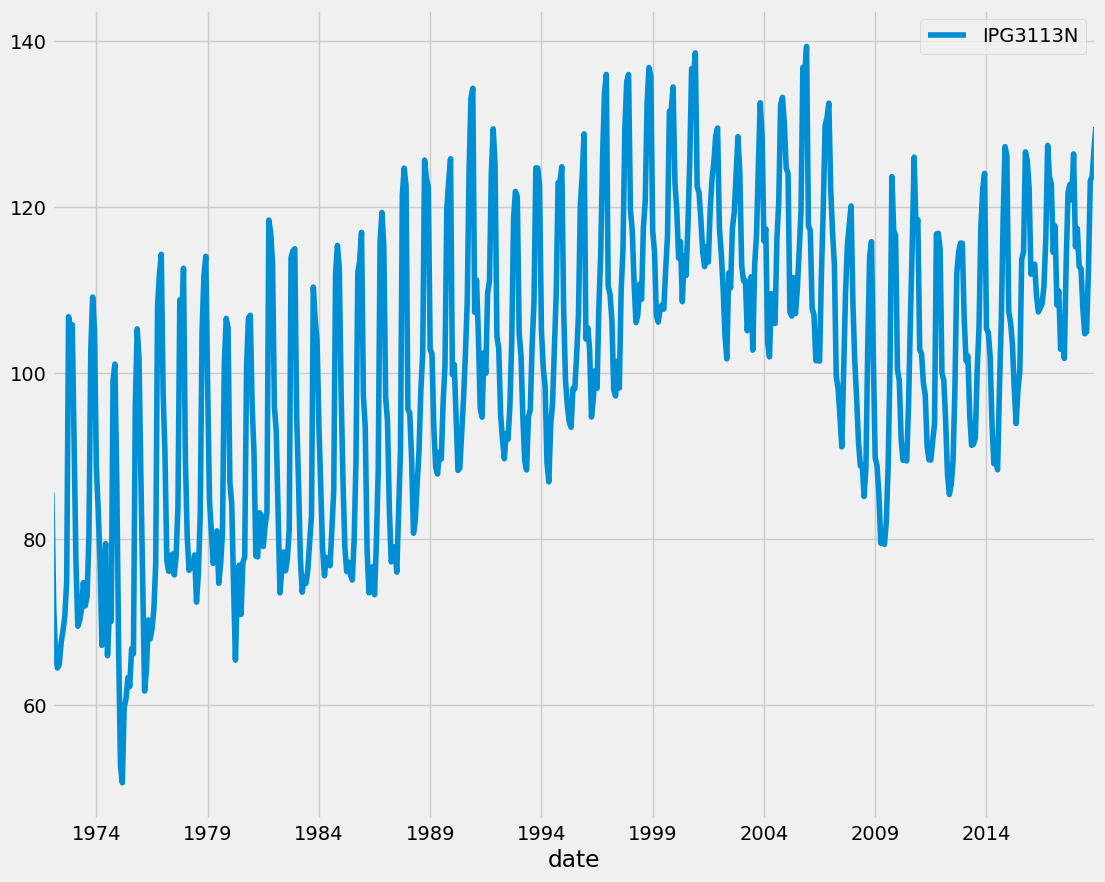

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Load in the time series
candy = pd.read_csv('Datasets/ARIMA/candy_production.csv', 
            index_col='date',
            parse_dates=True)
# change the plot style into fivethirtyeight 
plt.style.use('fivethirtyeight')

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
candy.plot(ax=ax1, figsize=(12,10))
plt.show()

Genel olarak, makine öğreniminde bir eğitim setiniz vardır, bu set üzerinde modelinizi uydurursunuz, ve bir test setiniz vardır, bu set üzerinde tahminlerinizi test edersiniz. Zaman serisi tahminleme de tam olarak aynıdır. Eğitim-test bölümümüz farklı olacaktır. Gelecekteki tahminlerde bulunmak için geçmiş değerleri kullanırız, bu nedenle veriyi zaman açısından bölmeliyiz. Zaman serisinde, zaman serisinin erken kısımlarında eğitim yaparız ve daha sonraki veriler üzerinde test yaparız. Aşağıda gösterildiği gibi DataFrame'in .loc methodunu kullanarak belirli bir tarihte zaman serisini bölebiliriz.


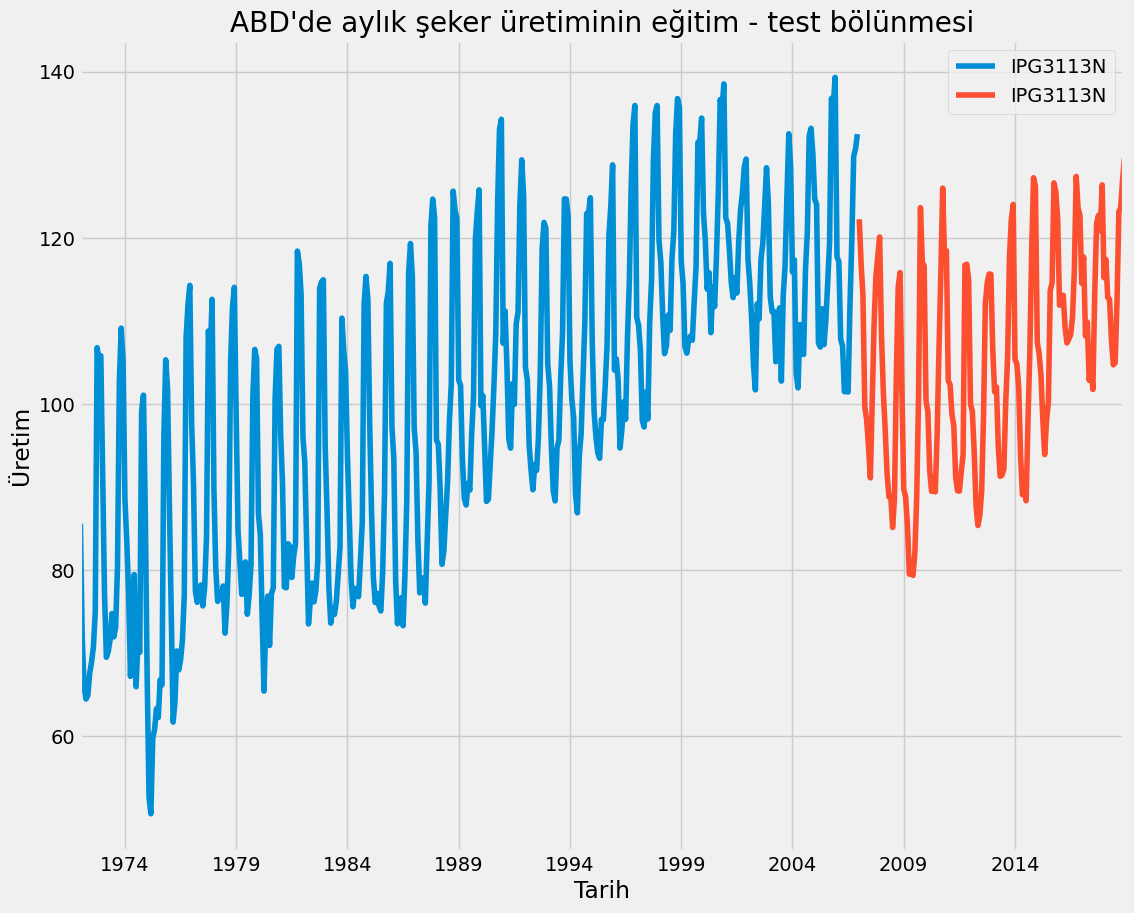

In [2]:
# Veriyi eğitim ve test setlerine bölelim
candy_egitim = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Bir eksen oluştur
fig, ax = plt.subplots()

# Eğitim ve test setlerini eksen ax üzerine çizelim
candy_egitim.plot(ax=ax, figsize=(12, 10))
candy_test.plot(ax=ax)
plt.title('ABD\'de aylık şeker üretiminin eğitim - test bölünmesi')
plt.xlabel('Tarih')
plt.ylabel('Üretim')
plt.show()


## Zaman Serisini Durağan Hale Getirmek
Zaman serisinin durağanlığını test etmenin birçok yolu vardır; bunlardan biri gözlemlerle yapılırken, diğerleri istatistiksel testler kullanarak daha doğru olanıdır. Ayrıca, durağan olmayan zaman serilerini durağan hale dönüştürmenin yolları da vardır. Bu alt bölümde her iki yöntemi ele alacağız ve ardından modellemeye başlamaya hazır olacaksınız.

Zaman serisinin durağan olup olmadığını belirlemede en yaygın testlerden biri, artırılmış Dickey-Fuller testidir. Bu, zaman serisinin eğilimler nedeniyle durağan olmadığını belirleyen bir istatistiksel testtir. artırılmış Dickey-Fuller testini uygulayabiliriz. İlk olarak, gösterildiği gibi statsmodels kütüphanesinden adfuller fonksiyonunu içe aktarıyoruz, ardından bu fonksiyonu şeker üretimi zaman serisi üzerinde çalıştırabiliriz


In [3]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(candy)
print(results)

(-1.7760153075016147, 0.39243275007139816, 14, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3094.828881317046)


Sonuç nesnesi bir demettir (tuple). Sıfırıncı eleman, bu durumda -1.77 olan test istatistiğidir. Bu sayı ne kadar negatifse, verinin o kadar muhtemelen durağan olduğu anlamına gelir. Sonraki öğe, test p-değeridir ve burada 0.3'tür. P-değeri 0.05'ten küçükse, null hipotezi reddedilir ve zaman serimizin durağan olduğunu varsayarız. Demetin son öğesi ise bir sözlüktür. Bu, test istatistiğinin farklı p-değerlerine eşit olan kritik değerlerini saklar. Bu durumda, 0.05 veya daha düşük bir p-değerine sahip olmak istiyorsak, test istatistiğimizin -2.86'dan daha düşük olması gerekiyordu.

Bu sonuca dayanarak, zaman serisinin durağan olmadığından emin oluyoruz. Bu nedenle, veriyi modele almadan önce onu durağan bir formata dönüştürmemiz gerekecek. Bunu klasik makine öğrenimindeki özellik mühendisliği gibi düşünebiliriz. Bir zaman serisini durağan hale getirmenin çok yaygın bir yolu, fark almak. Bu, zaman serisindeki her değerden önceki değeri çıkardığımız yerdir.

In [4]:
# İlk farkı hesapla ve NaN'leri kaldır
candy_diff = candy.diff()
candy_diff = candy_diff.dropna()

# Testi çalıştır ve sonucu yazdır
result_diff = adfuller(candy_diff)
print(result_diff)


(-6.1759124897557385, 6.631549159332682e-08, 13, 549, {'1%': -3.4423174665535385, '5%': -2.866818952732754, '10%': -2.569581505602171}, 3091.3123583091397)


Sonuçlardan görebildiğimiz gibi, şu anda zaman serileri stationarize edilmiş durumda. Bu sefer, fark almak, onu stationarize etmek için yeterliydi, ancak diğer zaman serileri için farkı birden fazla kez almak veya başka dönüşümler yapmak gerekebilir. Zaman serilerini stationarize etmek için diğer dönüşümleri gerçekleştirmemiz gerekebilir. Bu, bir zaman serisinin logaritmasını almak, karekökünü almak veya oransal değişimi hesaplamak gibi şeyleri içerebilir. Hangi dönüşümü yapacağımıza karar vermek bazen zor olabilir, ancak genellikle en basit çözüm en iyisidir.

## AR, MA ve ARMA modelleri
Otokorelasyonlu (AR) bir modelde, zaman serisinin değerlerini aynı zaman serisinin önceki değerlerine karşı regresyon yaparız. Basit bir AR modeli için denklem aşağıda gösterilmiştir:

y(t) = a(1) * y(t-1) + ϵ(t)

Zaman serisinin değeri (t) zamanındaki değer, bir önceki adımdaki zaman serisinin değerine parametre a(1) ile çarpılmış bir gürültü veya şok terimi ϵ(t) eklenmiştir. Şok terimi beyaz gürültüdür, yani her bir şok rastgele ve serideki diğer şoklarla ilişkili değildir. a(1) birinci lag'daki otokorelasyon katsayısıdır. Bu, bağımlı değişkenin y(t) olduğu basit bir lineer regresyon ile karşılaştırılabilir ve a(1) sadece çizginin eğimidir ve şoklar çizginin hatalarıdır.

Bu bir birinci dereceden AR modelidir. Modelin sırası kullanılan zaman gecikmelerinin sayısıdır. İkinci dereceden bir AR modeli, iki otokorelasyon katsayısına ve biri birinci lag'deki serilere ve diğeri ikinci lag'deki serilere olan iki bağımsız değişkene sahiptir. Daha genel olarak, p'nin AR modelinin derecesini ifade etmek için kullandığımız p'yi kullanırız. Bu, p otokorelasyon katsayısına sahip olduğumuz ve p gecikme kullandığımız anlamına gelir.

Hareketli ortalama (MA) modelinde, zaman serisinin değerlerini aynı zaman serisinin önceki şok değerlerine karşı regresyon yaparız. Basit bir MA modeli için denklem aşağıda gösterilmiştir:

y(t) = m(1)*ϵ(t-1) + ϵ(t)

Zaman serisinin değeri y(t), bir önceki adımdaki şok değerinin m(1) katıdır; artı mevcut zaman adımı için bir şok terimi. Bu birinci dereceden bir MA modelidir. Yine, modelin sırası kaç zaman gecikme kullandığımızı belirtir. Bir MA iki modeli, bir ve iki adım önceki şokları içerir. Daha genel olarak, q'nun MA modelinin derecesini ifade etmek için kullandığımız q'yu kullanırız.

ARMA modeli, AR ve MA modellerinin bir kombinasyonudur. Zaman serisi, önceki değerlere ve önceki şok terimlerine regresyon yapılır. Bu ARMA-bir-bir modelidir. Daha genel olarak, ARMA(p,q) kullanarak bir ARMA modelini tanımlarız. p bize modelin otoregresif kısmının derecesini söyler ve q bize hareketli ortalama kısmının derecesini söyler.

y(t) = a (1)y(t-1) + m(1) ϵ(t-1) + ϵ(t)

statsmodels paketini kullanarak hem ARMA modellerini uyumlaştırabilir hem de ARMA verisi oluşturabiliriz. Hadi bu ARMA-bir-bir modelini ele alalım. Diyelim ki bu katsayılarla veri simüle etmek istiyoruz. İlk olarak, arma_generate_sample fonksiyonunu içe aktarırız. Ardından AR ve MA katsayıları için listeler yaparız. Her iki katsayı listesi de bir ile başlar. Bu, sıfır gecikme terimi içindir ve bunu her zaman bir olarak ayarlayacağız. Birinci lag AR katsayısını 0.5 ve MA katsayısını 0.2 olarak ayarlarız. Veriyi oluştururken, katsayıları, oluşturulacak veri noktalarının sayısını ve şokların standart sapmasını geçiririz. Burada, aslında arzu ettiğimiz AR katsayılarının negatifini geçiririz. Bu, hatırlamamız gereken bir tuhaflıktır

In [6]:
from statsmodels.tsa.arima_process import arma_generate_sample
ar_coefs = [1, -0.5] 
ma_coefs = [1, 0.2]
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)


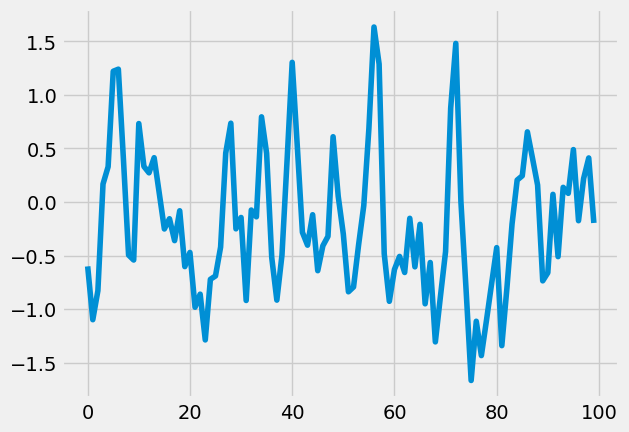

In [7]:
fig,ax = plt.subplots()
ax.plot(y)

y(t) = 0.5y(t−1) + 0.2* ϵ(t−1) + ϵ(t).

Fitting, bir sonraki bölümde ele alınacak, ancak işte bu veriyi nasıl uyumlayabileceğimize dair kısa bir bakış. İlk olarak, ARMA model sınıfını içe aktarıyoruz. Modeli örnekliyoruz, veriyi sağlıyoruz ve model düzenini tanımlıyoruz. Son olarak, uyum sağlıyoruz


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Model nesnesini oluştur
model = ARIMA(y, order=(1, 0, 1))

# Modeli uydur
results = model.fit()


## Geleceği Tahmin Etmek
Bu bölümde, zarif statsmodels paketini ARMA, ARIMA ve ARMAX modelleri uyarlama konusunda nasıl kullanacağınızı öğreneceksiniz. Ardından, modellerinizi kullanarak Amazon hisse senedi fiyatlarının belirsiz geleceğini tahmin edeceksiniz.

### Zaman Serisi Modellerinde Fit işlemi

zaman serisi modellerini eğitmek için önce statsmodels paketinden ARIMA model sınıfını içe aktarırız. Bir model nesnesi oluşturur ve model düzenini tanımlarız, ayrıca eğitim verilerini de iletmemiz gerekir. Veri bir pandas dataframe, bir pandas serisi veya bir NumPy dizisi olabilir. Unutmayın ki ARIMA modeli için düzen (p,d,q)'dur, burada p otoregresif gecikmeleri, d fark düzeyi ve q hareketli ortalama gecikmeleridir. d her zaman bir tamsayıdır, p ve q ise tamsayılar veya tamsayı listeleri olabilir. Bir AR modeli uydurmak için q sıfır olarak kullanabiliriz. Bir MA modeli uydurmak için ise p'yi sıfır yaparız.

Uydurulan modelin sonuç özetine bir göz atalım:

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Model nesnesini oluştur
model = ARIMA(y, order=(1, 0, 1))

# Modeli uydur
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -78.284
Date:                Mon, 11 Dec 2023   AIC                            164.567
Time:                        02:59:46   BIC                            174.988
Sample:                             0   HQIC                           168.785
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1967      0.128     -1.534      0.125      -0.448       0.055
ar.L1          0.4572      0.132      3.462      0.001       0.198       0.716
ma.L1          0.2445      0.163      1.503      0.1

Üst bölüm, uygun olan modelin sırası, gözlemler veya veri noktalarının sayısı ve zaman serisinin adı gibi kullanışlı bilgileri içerir. 


Özetin bir sonraki bölümü, uygun olan model parametrelerini gösterir. Burada ARIMA(1,0,1) modeli uyguladık, bu nedenle model AR-lag-1 ve lag-1 katsayılarına sahiptir. Tabloda bunlar ar.L1 ve ma.L1 satırlarıdır. lag-1 MA katsayısı en alt satırdadır. İlk sütun model katsayılarını, ikinci sütun ise bu katsayılardaki standart hatayı gösterir. Bu, uyarlanmış katsayı değerlerindeki belirsizliktir.

ARMA modeline yapılabilecek bir uzantı, ARMAX modelini oluşturmak için dışsal girdileri kullanmaktır. Bu, zaman serisini zaman serisi kendisiyle birlikte diğer bağımsız değişkenleri kullanarak modelleme anlamına gelir. Bu, bir ARMA modeli ile normal bir lineer regresyon modeli arasında bir kombinasyon gibidir. İki basit ARMA ve ARMAX modelinin denklemleri burada gösterilmektedir. Tek fark, bir ek terimdir. Yeni bir bağımsız değişken z(t) ve onun katsayısı x(1) ekleriz. ARMAX'ın neden faydalı olabileceği bir örnek üzerinde düşünelim.

ARMA(1,1) modeli:

y(t) = a(1) y(t-1) + m(1) ϵ(t-1) + ϵ(t)

ARMAX(1,1) modeli:

y = x(1)* z(t) + a(1) y(t-1) + m (1)ϵ(t-1) + ϵ(t)

ARMAX modelini, önce kullandığımız ARMA modeli sınıfını kullanarak uygulayabiliriz. Tek fark, şimdi exog anahtar kelimesini kullanarak dışsal değişkenimizi ileteceğiz. Model sırası ve uyarlama prosedürü aynıdır.

### Tahminleme
ARIMA modellerini verilere uyarlama konusunu sunduktan sonra, bunları geleceği tahmin etmek ve öngörmek için nasıl kullanacağımıza bakalım. Bir AR(1) modelini temsil eden bir zaman serisi örneğini ele alalım. Zaman serisinde herhangi bir zamanda, önceki değeri gecikme bir AR katsayısıyla çarparak sonraki değerleri tahmin edebiliriz. Eğer önceki değer 15 ise ve katsayı a-bir 0.5 ise, bir sonraki değerin 7.5 olduğunu tahmin ederiz. Eğer şok terimi standart sapması 1 ise, alt ve üst belirsizlik sınırlarımızı 6.5 ve 8.5 olarak tahmin ederiz. Bu tür tahminleme, adım-adım öngörme olarak adlandırılır. Aşağıda denklemi bulunmaktadır:

y = 0.5 x 15 + ϵ(t)

### Non-stationary zaman serileri için ARIMA modelleri
Eğer tahmin etmeye çalıştığınız zaman serisi durağan değilse, ARMA modelini uygulayamazsınız. Önce onu durağan hale getirmemiz gerekiyor ve ardından bunun için ARMA modelini kullanabiliriz. Ancak bunu yaptığımızda, zaman serisinin fark değerini tahmin etmek üzere eğitilmiş bir modelimiz olacaktır. Gerçekten tahmin etmek istediğimiz şey, farkın değil, zaman serisinin gerçek değeridir. Bu, fark değerlerinin tahminini dikkatlice dönüştürerek başarılabilir.

Fark değeri tahminleriyle başlarız. Farkın alınmasının tersi, kümülatif toplam veya integral almaktır. Bu dönüşümü kullanmamız gerekecek; fark değerlerinin tahminlerinden mutlak değer tahminlerine geçmek için.

Bunu np.cumsum fonksiyonunu kullanarak yapabiliriz. Bu fonksiyonu uygularsak, artık bir tahminimiz var: zaman serisi, tahmin dönemi boyunca başlangıç ​​değerinden ne kadar değiştiğini. Mutlak bir değer elde etmek için bunun üzerine orijinal zaman serisinin son değerini eklememiz gerekiyor.

In [10]:
from numpy import cumsum
mean_forecast = cumsum(candy_diff) + candy.iloc[-1, 0],


Non-stationary verilerle başlamak, onları stationary hale getirmek için differencing işlemi uygulamak ve ardından tahminleme entegrasyon adımları, zaman serisi modellemede oldukça yaygındır. Bu oldukça fazla iş! Ancak neyse ki, bunu bizim için yapan ARMA modelinin bir genişlemesi bulunmaktadır! Bu, otoregressif entegre hareketli ortalama modeli (ARIMA) olarak adlandırılır.

ARIMA modelini statsmodels kütüphanesinden SARIMAX model sınıfını kullanarak uygulayabiliriz. ARIMA modelinin üç model sırası bulunmaktadır. Bunlar, p otoregressif sırası; d differencing sırası ve q hareketli ortalama sırasıdır. Önceki bölümde, ortadaki sıra parametresini d'yi sıfır olarak ayarlıyorduk. Eğer d sıfırsa, basitçe bir ARMA modeline sahibiz demektir.

Bu modeli kullandığımızda, ona differencing uygulanmamış bir zaman serisi ve model sırasını geçiririz. Veriyi sadece bir kez differencing uygulamak ve ardından ARMA(2,1) modelini uygulamak istiyorsak, bunu ARIMA(2,1,1) modeli kullanarak elde ederiz. Differencing parametresini belirttikten sonra, differencing ile ilgilenmemize gerek kalmaz. Modeli önceki gibi uyumlaştırır ve tahminler yaparız. Differencing ve entegrasyon adımları, model nesnesi tarafından otomatik olarak ele alınır. Bu, non-stationary zaman serileri için tahmin almanın çok daha kolay bir yoludur!

Yine de doğru düzeyde fark alma konusunda dikkatli olmalıyız. Unutmayın, verilerimizi sadece durağan hale geldiğinde ve daha fazla gerek kalmadığında fark alırız. Modelimizi uygulamadan önce, fark derecesini belirlemek için artırılmış Dicky-Fuller testini kullanacağız. Bu sayede modeli uygulama aşamasına geldiğimizde hangi fark derecesini uygulamamız gerektiğini zaten bileceğiz.

Bunu gerçek veriye uygulayalım. Kullanılacak veri Amazon hisse senedi fiyatları verisidir. İki yöntemi de uygulayacağız. İlk olarak, bir fark ile veri üzerine ARMA modelleri uygulanacak ve ardından yerleşik fark kullanılarak ARIMA modeli uygulanacaktır. İlk olarak, veri yüklenecek ve çizilecektir.

Text(0, 0.5, 'Hisse senedi fiyatı')

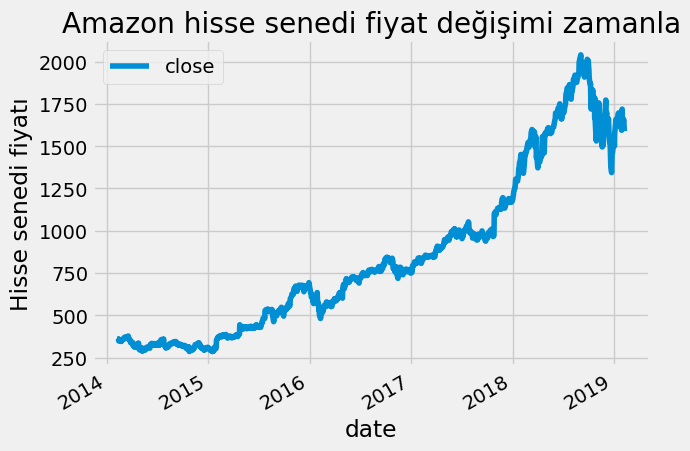

In [11]:
amazon = pd.read_csv('Datasets/ARIMA/amazon_close.csv',
                     index_col='date',
                     parse_dates=True)
amazon.plot()
plt.title('Amazon hisse senedi fiyat değişimi zamanla')
plt.ylabel('Hisse senedi fiyatı')


İlk olarak, zaman serisinin durağan (stationary) olup olmadığını anlamak için Adfuller-Dickey testini uygulayacağız."

In [12]:
from statsmodels.tsa.stattools import adfuller

# Dicky-Fuller testini çalıştır
result = adfuller(amazon)

# Test istatistiğini yazdır
print('Test İstatistiği:', result[0])

# p-değerini yazdır
print("p-değer:", result[1])


Test İstatistiği: -1.3446690965325956
p-değer: 0.6084966311408425


P değeri 0.05'ten büyük olduğu için, boş hipotezi reddedemeyiz ve zaman serisinin durağan olmadığı kabul edilir. Bu nedenle, ilk farkı alacağız ve bunun zaman serisini durağan yapıp yapmadığını Adfuller-Dickey testini kullanarak kontrol edeceğiz.

In [13]:
# İlk farkı al
amazon_diff = amazon.diff()
amazon_diff.dropna(inplace=True)

# Dicky-Fuller testini çalıştır
result = adfuller(amazon_diff)

# Test istatistiğini yazdır
print('Test istatistiği:', result[0])

# p-değerini yazdır
print("p-değer:", result[1])


Test istatistiği: -7.203579488811133
p-değer: 2.3312717254886556e-10


Amazon hisse senedi fiyatı zaman serisinin ilk farkını aldıktan sonra elde edilen p-değeri 0.05'ten küçüktür, bu nedenle boş hipotezi reddedebiliriz ve veri artık durağan kabul edilir. Modelleme aşamasında, yukarıda belirtilen iki yolun birini takip edebiliriz. İlk olarak, ARMA modelini kullanın ve veri üzerine ilk farkı uygulayın. Ardından, tahmin yapmak için np.cumsum fonksiyonunu kullanacağız, bu sayede tahmin gerçek veri üzerinden değil, fark alınmış veri üzerinden yapılacaktır.

In [15]:
from statsmodels.tsa.arima.model import ARIMA
# Model nesnesini başlat
model = ARIMA(amazon_diff, order=(1, 0, 1))
# Modeli uydur
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5536.175
Date:                Mon, 11 Dec 2023   AIC                          11080.350
Time:                        03:12:01   BIC                          11100.900
Sample:                             0   HQIC                         11088.073
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9877      0.457     -2.160      0.031      -1.884      -0.092
ar.L1          0.8267      0.078     10.556      0.000       0.673       0.980
ma.L1         -0.8603      0.072    -11.866      0.0

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monoto

İkinci yöntem, ARIMA modelini kullanmak ve gerçek verileri kullanarak ARIMA fonksiyonundaki 'difference' parametresini kullanmaktır.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# Model nesnesini oluştur
model = ARIMA(amazon, order=(1, 1, 1))

# Modeli uyumla
results = model.fit()

# Sonuçları yazdır
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5538.450
Date:                Mon, 11 Dec 2023   AIC                          11082.901
Time:                        03:12:48   BIC                          11098.312
Sample:                             0   HQIC                         11088.693
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8065      0.104      7.726      0.000       0.602       1.011
ma.L1         -0.8352      0.099     -8.450      0.000      -1.029      -0.641
sigma2       390.4373      5.974     65.352      0.0

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monoto

Bu not defterinin ikinci bölümünde, en iyi model parametresini seçmek için otokorelasyon fonksiyonu (ACF) ve kısmi otokorelasyon fonksiyonu (PACF) çizimlerini ve Akaike bilgi kriteri (AIC) ile Bayesian Bilgi Kriteri'ni (BIC) kullanma yöntemini tartışacağız. Ardından, seçeneklerimizi daraltmak için Box-Jenkins yöntemini ele alacağız. Daha sonra, ham zaman serilerinden üretime hazır bir modele gitmenize yardımcı olacak. Son olarak, bu yaklaşımı mevsimsel zaman serilerine nasıl uygulayacağımızı tartışacağız.

## En İyi ARIMA Modellerini Bulma
Bu bölümde, veriden umut verici model düzenlerini nasıl belirleyeceğimizi öğreneceğiz. Ardından, en umut verici modeller eğitildikten sonra bu eğitilmiş seçimden en iyi modeli seçmeyi öğreneceksiniz. Ayrıca, Box-Jenkins yöntemini kullanarak zaman serisi projenizi nasıl yapılandırmanız gerektiğini öğreneceksiniz.

## En iyi model parametrelerini bulmak için ACF ve PACF kullanma
Önceki bölümde, ARIMA modelini tahmin etmek için nasıl kullanacağımızı biliyorduk, ancak tahmin modelinin düzenini nasıl seçeceğimizi tartışmadık. Model düzeni, tahminlerin kalitesini etkileyen çok önemli bir parametredir. Doğru model düzenini belirlemenin en iyi yollarından biri otokorelasyon fonksiyonu (ACF) ve kısmi otokorelasyon fonksiyonu (PACF)'dir.

ACF, bir zaman serisi ile kendisi arasındaki n gecikme ile korelasyon olarak tanımlanabilir. Bu nedenle ACF(1), zaman serisi ile bir adım gecikmiş bir versiyonu arasındaki korelasyondur. ACF(2), zaman serisi ile bir adım gecikmiş bir versiyonu arasındaki korelasyondur ve böyle devam eder. ACF'yi daha iyi anlamak için, deprem zaman serisi için on gecikme için çizelim.

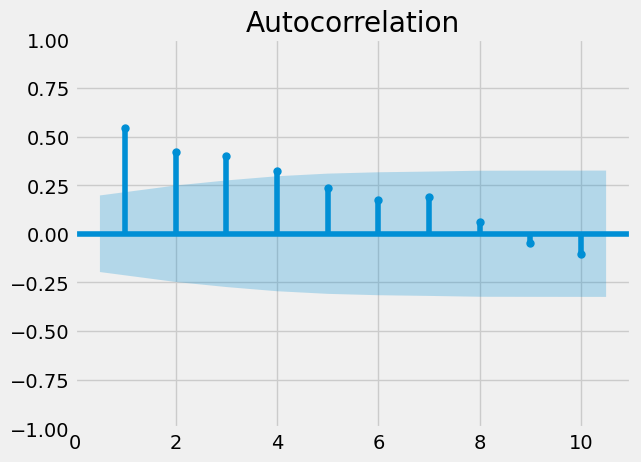

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

deprem = pd.read_csv('Datasets/ARIMA/earthquakes.csv')
# ACF grafiğini oluştur
plot_acf(deprem['earthquakes_per_year'], lags=10, zero=False)
plt.show()



Yukarıdaki figürdeki çubuklar, her zaman aralığındaki zaman serisinin kendisiyle olan korelasyonunu gösterir. Eğer çubuk mavi gölgeli bölgenin içinde ise, bu istatistiksel olarak anlamlı olmadığı anlamına gelir.

Diğer taraftan, PACF (Parçalı Otoregresif Fonksiyon) zaman serisi ile kendisinin bir gecikmiş versiyonu arasındaki korelasyonu gösterir, daha küçük gecikmelerdeki korelasyon etkisini çıkardıktan sonra. Bu nedenle, belirli bir gecikmedeki korelasyon olarak düşünülebilir. PACF'yi daha iyi anlamak için, deprem zaman serisi için on gecikme için çizelim.

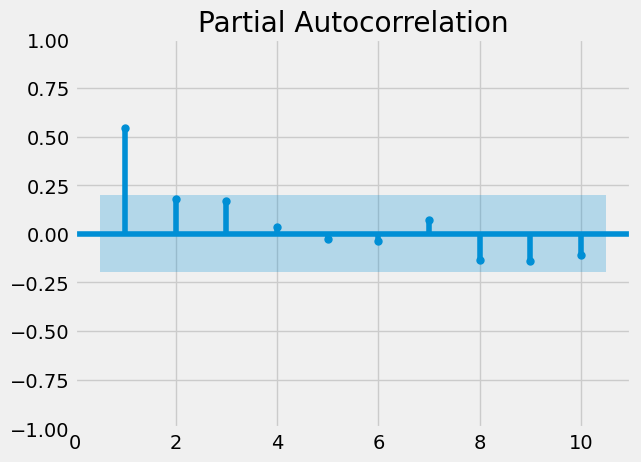

In [19]:
plot_pacf(deprem['earthquakes_per_year'], lags=10, zero=False)
plt.show()


Yukarıdaki grafikteki çubuklar, küçük gecikmelerin korelasyon etkisini çıkardıktan sonra zaman serisi ile kendi kendisi arasındaki korelasyonu gösterir. Eğer çubuk mavi gölgeli bölgenin içindeyse, bu istatistiksel olarak anlamlı olmadığı anlamına gelir.

***Bu grafikleri oluşturmadan önce zaman serisinin durağan hale getirilmiş olması gerekir. Eğer ACF değerleri yüksekse ve çok yavaş bir şekilde azalıyorsa, bu verinin durağan olmadığına dair bir işarettir ve farklılaştırılması gerekir. Öte yandan, eğer lag-1'deki otokorelasyon çok negatifse, bu da farkı çok fazla kez almış olabileceğimize dair bir işarettir.***

Zaman serisinin ACF ve PACF'sini karşılaştırarak model sırasını belirleyebiliriz. Üç ana olasılık vardır:

* AR(p) modeli: ACF yavaşça azalır ve PACF lag p'den sonra kesilir. 

* MA(q) modeli: ACF'nin genliği q gecikme sonrasında kesilirken, PACF kuyruklanır.
  
* ARIMA(p, q) modeli: Hem ACF'nin hem de PACF'nin genliği kesilirse, bu ARIMA modeli olacaktır, ancak model sıralarını (p, q) çizimden çıkaramayız.
  
Bu durumu deprem zaman serilerine uygulayalım, önce ACF ve PACF'yi çizdik. ACF'nin kuyruklanırken PACF'nin 1 gecikme sonrasında kesildiği görünüyor. Bu nedenle, ilk durumu takip eder ve zaman serisi bir AR(1) modeli kullanılarak modellenebilir.

## AIC ve BIC'yi kullanarak model seçimini daraltma

Üçüncü durumda, ACF ve PACF'nin amplitüdünün her ikisi de kesildiğinde, zaman serisi bir ARIMA(p, q) modeli kullanılarak modelleme yapılabilir. Ancak, modelin sırası (p, q) ACF ve PACF grafiğinden belirlenebilir. Ancak, Akaike bilgi kriteri (AIC) ve Bayesian bilgi kriteri (BIC) değerlerini bulmak için kullanılabilir.

Hem AIC hem de BIC için daha düşük değerler daha iyi bir modeli işaret eder. AIC ve BIC her ikisi de çok sayıda parametreye sahip karmaşık modelleri cezalandırır. Bununla birlikte, bu modelleri cezalandırma ve model karmaşıklığını ne kadar cezalandırdıkları konusunda farklılık gösterirler. BIC, AIC'den daha fazla model sırasını cezalandırır, bu nedenle BIC bazen AIC'den daha basit bir model önerir. Genellikle aynı modeli önerirler, ancak öyle değilse, önceliklerinize bağlı olarak birini seçmeniz gerekecektir. Eğer amacınız daha iyi bir kestirim modeli bulmaksa, o zaman AIC daha iyi bir seçenek olacaktır ve amacınız iyi bir açıklayıcı model bulmaksa, o zaman BIC iyi bir seçenek olacaktır.

Bunu daha önce kullanılan deprem veri kümesine uygulayalım ve ACF/PACF kullanarak elde ettiğimiz sonuçları AIC ve BIC kullanarak karşılaştıralım. Veriyi en iyi şekilde uyduracak olan modelin AR(1) olduğunu öne sürüyoruz. Farklı p ve q varyasyonları için 0 ile 2 arasından başlayarak AIC ve BIC'yi hesaplayacağız.


In [20]:
import statsmodels.api as sm
order_aic_bic =[]

# p değerlerini 0-2 arasında döngü yap
for p in range(3):
    # q değerlerini 0-2 arasında döngü yap
    for q in range(3):
      
        try:
            # ARMA(p,q) modelini oluştur ve uyumla
            model = sm.tsa.statespace.SARIMAX(deprem['earthquakes_per_year'], order=(p, 0, q))
            results = model.fit()
            
            # Sıralamayı ve sonuçları yazdır
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Model sırası ve AIC/BIC skorlarını içeren DataFrame oluştur
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

# AIC'ye göre sırala
print("AIC'ye göre sıralı ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# BIC'ye göre sırala
print("BIC'ye göre sıralı ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47692D+00    |proj g|=  2.21156D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.212D-08   4.477D+00
  F =   4.4769180418808485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.2

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.
 This problem is unconstrained.


Sonuçlar, veriyi en iyi uyduran modelin (1,1) olduğunu gösteriyor; bu, PACF/ACF kullanılarak bulunan değerden farklıdır.

## Model BiLgileri
Sonraki adım, modelin davranışının iyi olup olmadığını anlamak için modeli teşhis etmektir. Modeli teşhis etmek için eğitim verisinin artıklarına odaklanacağız. Artıklar, modelin bir adım önceki tahminleri ile zaman serisinin gerçek değerleri arasındaki farklardır.

Statsmodels'te eğitim dönemi artıklarına results nesnesinin dot-resid özelliği aracılığıyla erişilebilir. Sonuçlar, bir pandas serisi olarak saklanır. Bu, aşağıdaki kod örneğinde gösterilmiştir:

In [21]:
# En iyi p ve q değerleriyle bulunan model
model = sm.tsa.statespace.SARIMAX(deprem['earthquakes_per_year'], order=(1, 0, 1))
# Modeli uyumla
sonuclar = model.fit()
# Kalanları bir değişkene ata
hatalar = sonuclar.resid
print(hatalar)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24438D+00    |proj g|=  6.79014D-02

At iterate    5    f=  3.23891D+00    |proj g|=  7.28400D-04

At iterate   10    f=  3.23870D+00    |proj g|=  1.18872D-02

At iterate   15    f=  3.23804D+00    |proj g|=  3.81182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   8.733D-07   3.238D+00
  F =   3.2380419190271787     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0     13

 This problem is unconstrained.


Gerçek değerden ne kadar uzak olduğunu bilmek için, hata terimlerinin ortalama mutlak hatasını hesaplayabiliriz. Bu aşağıdaki kodda gösterilmiştir:

In [23]:
import numpy as np
mae = np.mean(np.abs(hatalar))
print(mae)


4.755625669456648


İdeal model, hataların sıfır merkezli, bağımsız ve beyaz Gaussian gürültüsü olması gerekmektedir. Bu durumu değerlendirmek için results nesnesinin .plot_diagnostics yöntemini kullanabiliriz. Bu için kullanılacak kod aşağıda gösterilmiştir:

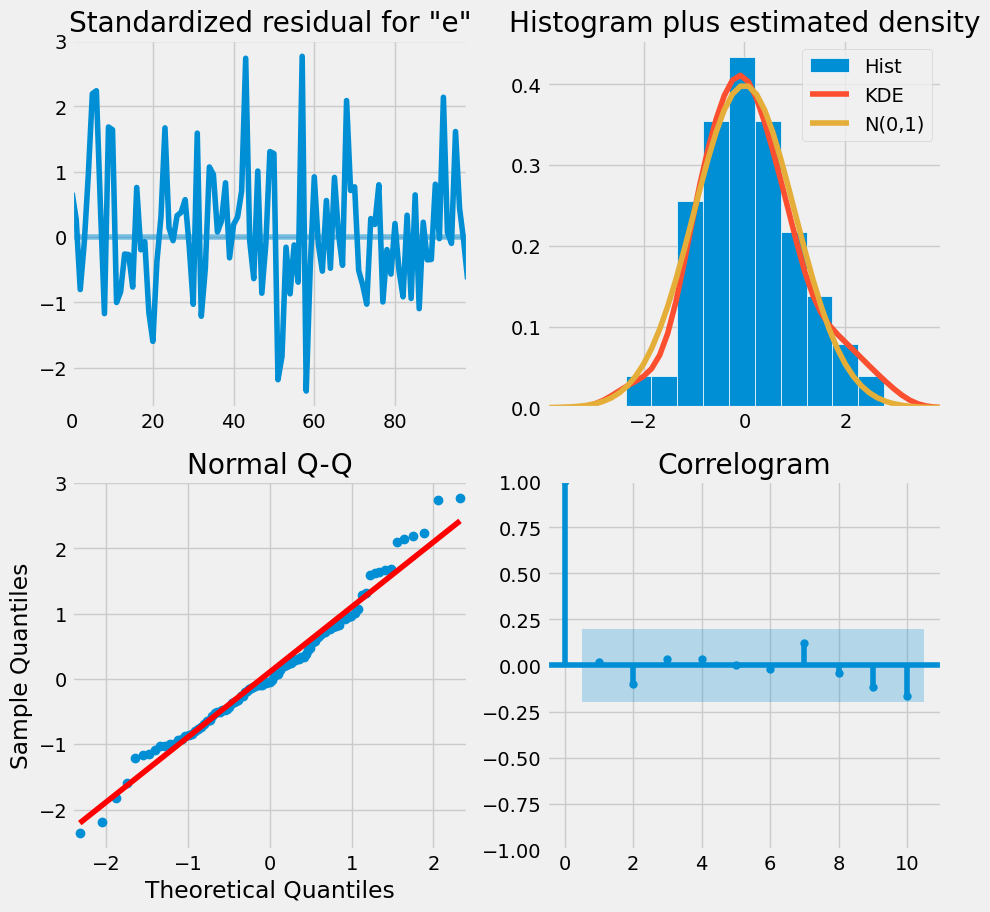

In [24]:
sonuclar.plot_diagnostics(figsize=(10,10))
plt.show()

Model hata teşhis grafiğinde dört çizim bulunmaktadır:

* Standartlaştırılmış hata grafiği: Sol üstteki çizim, bir adım önceki standartlaştırılmış hataları gösterir. Modelimiz düzgün çalışıyorsa, hatalarda belirgin bir desen olmamalıdır. Bu durum bu örnekte gösterilmiştir.

* Histogram ve tahmini yoğunluk çizimi: Bu çizim, hataların dağılımını gösterir. Histogram, ölçülen dağılımı gösterir; turuncu çizgi bu histogramın düzleştirilmiş bir versiyonunu gösterir ve yeşil çizgi normal bir dağılımı gösterir. Model iyi çalışıyorsa, bu iki çizgi aynı olmalıdır. Burada küçük farklar vardır, bu da modelimizin iyi çalıştığını gösterir.

* Normal Q-Q çizimi: Q-Q çizimi, hataların dağılımını normal dağılıma karşı karşılaştırır. Eğer hataların dağılımı normal ise, o zaman tüm noktalar kırmızı çizgi boyunca olmalıdır, sadece bazı değerler hariç.

* Korelasyon çizimi: Korelasyon çizimi, veri değil, hataların ACF çizimidir. Sıfırdan büyük gecikmeler için korelasyonların %95'i anlamlı olmamalıdır (mavi tonlarda). Eğer hatalarda anlamlı bir korelasyon varsa, bu, model tarafından yakalanmayan verilerde bilgi olduğu anlamına gelir.

Model hatalarının özet istatistiklerini almak için sonuçların .summary metodunu kullanabiliriz. Aşağıda gösterilen sonuç tablosunda, Prob(Q), hataların herhangi bir korelasyon yapısına sahip olmadığı null hipotezi ile ilişkilendirilen p-değeri içerir. Prob(JB), hataların Gauss normalliğine sahip olmadığı null hipotezi ile ilişkilendirilen p-değeridir. Her iki p-değerinden biri 0.05'ten küçükse, bu hipotezi reddederiz.

In [27]:
print(sonuclar.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                -320.566
Date:                  Mon, 11 Dec 2023   AIC                            647.132
Time:                          03:43:04   BIC                            654.918
Sample:                               0   HQIC                           650.282
                                   - 99                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9893      0.014     70.282      0.000       0.962       1.017
ma.L1         -0.5517      0.089     -6.198      0.000      -0.726      -0.377
sigma2        37.0254      4.980    

Prob(Q) ve Prob(JB) değerleri her ikisi de 0.05'ten büyük olduğu için, rezidüallerin Gauss'a normal dağılmış olduğu null hipotezini reddedemeyiz.

## Box-Jenkins Yöntemi
Box-Jenkins yöntemi, ham verilerden üretime hazır bir modele gitmenize yardımcı olan bir kontrol listesidir. Bu yöntemde, ham verilerden üretime hazır bir modele gitmek için izlenecek üç ana adım bulunmaktadır: tanımlama, tahmin, model teşhisleri ve model teşhislerine dayalı kararlar. Bu süreç aşağıdaki şekilde özetlenebilir.

Tanımlama
Tanımlama adımında, veriyi keşfeder ve karakterize ederiz, böylece tahmin adımında kullanılmak üzere uygun veri formunu bulabiliriz. İlk olarak, verinin durağan olup olmadığını inceleyeceğiz. Eğer veri durağan değilse, veriyi durağan hale getirecek dönüşümü bulacağız ve nihayetinde en umut verici p ve q düzenini belirleyeceğiz.

Bu adımda kullanılan araçlar, çizim, artırılmış Dickey-Fuller testi, fark alma ve diğer dönüşümler (örneğin, logaritmik dönüşüm) ile ACF ve PACF'dir.

Tahmin
Tahmin adımında, model eğitilir ve verinin AR ve MA katsayıları elde edilir. Bu, model.fit yöntemi tarafından otomatik olarak yapılır. Bu adımda birçok modeli sığdırabilir ve onları daha umut verici modellere daraltmak için BIC ve AIC kullanabiliriz.

Model Teşhisleri
Teşhis adımında istatistiksel testler ve çizimlerden elde edilen bilgileri kullanarak bir karar vermemiz gerekiyor. Model yeterince iyi mi, yoksa geri dönüp üzerinde tekrar çalışmamız mı gerekiyor? Eğer artıklar beklenildiği gibi değilse, önceki iki adımda yaptığımız seçimleri tekrar düşünmek üzere geri döneriz. Eğer artıklar uygunsa, öngörüler yapabiliriz!

Bu, zaman serisi modelleri geliştirirken genel proje iş akışınızdır. İyi uyan bir model oluşturmak için süreci birkaç kez tekrar etmeniz gerekebilir.

Box-Jenkins yöntemini yeni bir veri setine uygulayalım. Kullanılacak veri, 1958'den 2018'e kadar olan CO2 emisyonlarıdır. Üç adımı takip edeceğiz. İlk olarak, tanımlama ile başlayacağız. İlk olarak, aşağıdaki kodu kullanarak veriyi yükleyip çizeceğiz."

<Axes: xlabel='date'>

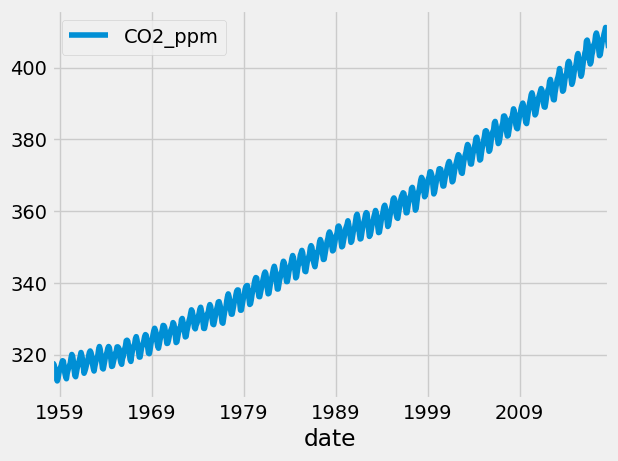

In [28]:
co2 = pd.read_csv('Datasets/ARIMA/co2.csv',
                     index_col='date',
                     parse_dates=True)
co2.plot()

In [29]:
# Veride bir eğilim olduğu açıktır. Ardından, artırılmış Dickey-Fuller testini uygulayacağız.

from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller testini çalıştır
sonuc = adfuller(co2)

# Test istatistiğini yazdır
print('Test istatistiği:', sonuc[0])

# p değerini yazdır
print("p değeri:", sonuc[1])


Test istatistiği: 4.774866785205466
p değeri: 1.0


P-değeri 1 olduğundan, zaman serisinin durağan olmayan (non-stationary) hipotezini reddedemeyiz. Bunun durağan hale getirilmesi için ilk farkını alalım, çizelim ve artırılmış Dickey-Fuller testini uygulayalım.

Test istatistiği: -5.287425631615243
P-değeri: 5.813789175333085e-06


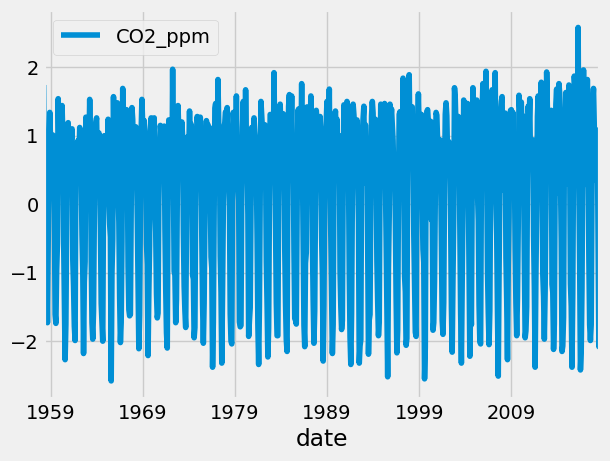

In [30]:
# co2 serisinin ilk farkını al
co2_diff = co2.diff()
co2_diff = co2_diff.dropna()
co2_diff.plot()

# Dickey-Fuller testini çalıştır
result_diff = adfuller(co2_diff)

# Test istatistiğini yazdır
print('Test istatistiği:', result_diff[0])

# P-değerini yazdır
print("P-değeri:", result_diff[1])


P-değeri 0.05'ten küçük olduğu için null hipotezi reddedilebilir ve verinin durağan olduğu varsayılabilir. CO2 verilerinin ilk farkı yukarıdaki figürde gösterilmiştir.

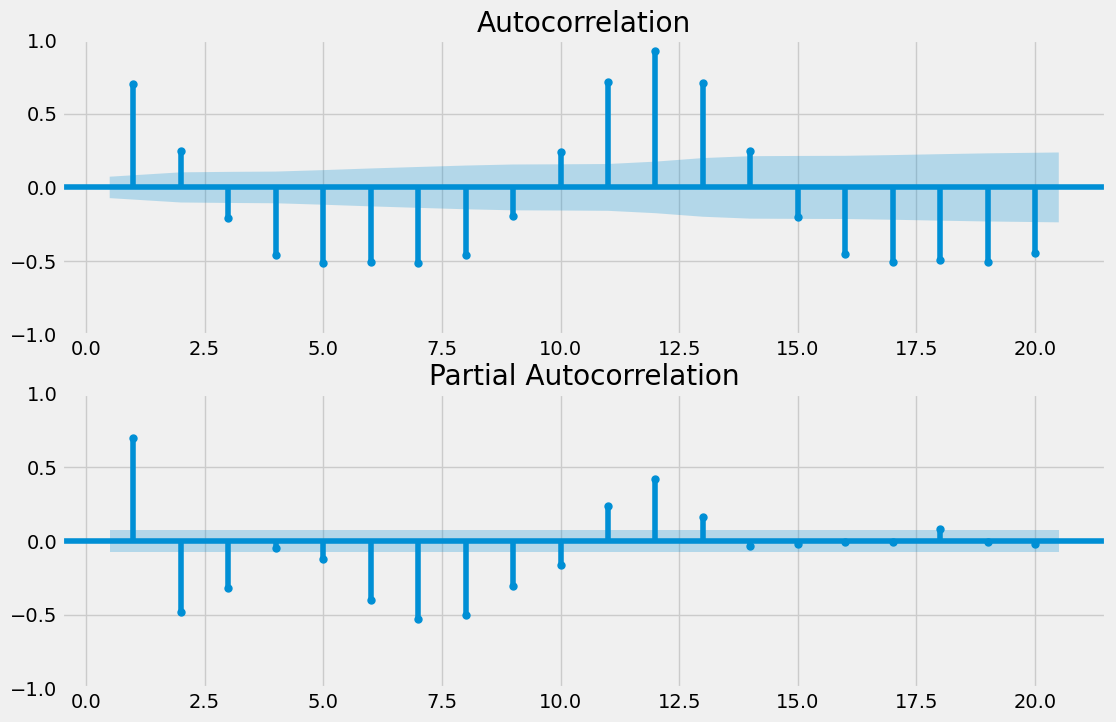

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Figür oluştur
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
 
# ax1 üzerinde CO2 verisinin ACF'sini çiz
plot_acf(co2_diff, lags=20, zero=False, ax=ax1)

# ax2 üzerinde CO2 verisinin PACF'sini çiz
plot_pacf(co2_diff, lags=20, zero=False, ax=ax2)

plt.show()

ACF ve PACF grafiği belirli bir desleyi takip etmiyor. Bu nedenle model düzenini tanımlamak zor olacaktır. Bu yerine, AIC ve BIC'yi kullanarak model düzeni seçimini daraltacak ve ardından veriyi en iyi modele uygun hale getireceğiz. Bu, tahmin adımı olan ikinci adımdır.

In [32]:
import statsmodels.api as sm
order_aic_bic =[]

# p değerlerini 0-4 arasında döngüye al
for p in range(5):
    # q değerlerini 0-4 arasında döngüye al
    for q in range(5):
      
        try:
            # ARMA(p,q) modelini oluştur ve uyumla
            model = sm.tsa.statespace.SARIMAX(co2, order=(p, 1, q))
            results = model.fit()
            
            # Sıralama ve sonuçları yazdır
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Model sırası ve AIC/BIC skorlarının DataFrame'i
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

# AIC ve BIC'ye göre sıralama yapalım

# AIC'ye göre sırala
print("AIC'ye göre sıralanan modeller")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# BIC'ye göre sırala
print("BIC'ye göre sıralanan modeller")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))


/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62713D+00    |proj g|=  1.10868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.010D-06   1.627D+00
  F =   1.6271294104890168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain


At iterate   10    f=  1.16903D+00    |proj g|=  6.12441D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   6.124D-06   1.169D+00
  F =   1.1690319746897113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06050D+00    |proj g|=  2.70917D+00

At iterate    5    f=  1.15573D+00    |proj g|=  1.17669D-01

At iterate   10    f=  1.13473D+00    |proj g|=  2.67141D-03

       

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS w


At iterate   10    f=  1.08884D+00    |proj g|=  3.46268D-02

At iterate   15    f=  1.08822D+00    |proj g|=  4.16839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.750D-06   1.088D+00
  F =   1.0882231947700642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15139D+00    |proj g|=  3.24329D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10028D+00    |proj g|=  1.31302D-01

At iterate    5    f=  1.05045D+00    |proj g|=  3.83128D-02

At iterate   10    f=  1.04414D+00    |proj g|=  2.62252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.891D-05   1.044D+00
  F =   1.0441298939496244     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   15    f=  1.11712D+00    |proj g|=  1.75579D-01

At iterate   20    f=  1.04391D+00    |proj g|=  3.12227D-02

At iterate   25    f=  1.04096D+00    |proj g|=  1.83744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     41      1     0     0   7.429D-06   1.041D+00
  F =   1.0409522574783419     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63374D+00    |proj g|=  2.59840D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  8.87990D-01    |proj g|=  2.02235D-02

At iterate   25    f=  8.87709D-01    |proj g|=  5.41965D-04

At iterate   30    f=  8.87691D-01    |proj g|=  3.25408D-03

At iterate   35    f=  8.85551D-01    |proj g|=  5.55127D-02

At iterate   40    f=  8.82461D-01    |proj g|=  3.87652D-03

At iterate   45    f=  8.82434D-01    |proj g|=  6.03106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     64      1     0     0   1.150D-05   8.824D-01
  F =  0.88243358394180071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain


At iterate    5    f=  1.10509D+00    |proj g|=  4.67509D-02

At iterate   10    f=  1.05178D+00    |proj g|=  5.10026D-02

At iterate   15    f=  1.04494D+00    |proj g|=  3.21703D-02

At iterate   20    f=  1.04413D+00    |proj g|=  3.29743D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   3.297D-05   1.044D+00
  F =   1.0441304430869791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame


At iterate   20    f=  1.04379D+00    |proj g|=  3.87693D-03

At iterate   25    f=  1.04357D+00    |proj g|=  9.02110D-03

At iterate   30    f=  1.04352D+00    |proj g|=  2.22954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   2.677D-05   1.044D+00
  F =   1.0435149786696014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77413D+00    |proj g|=  2.94530D+00

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  8.98539D-01    |proj g|=  2.91517D-02

At iterate   25    f=  8.93084D-01    |proj g|=  1.23113D-02

At iterate   30    f=  8.92897D-01    |proj g|=  2.07256D-02

At iterate   35    f=  8.92733D-01    |proj g|=  3.96026D-03

At iterate   40    f=  8.89385D-01    |proj g|=  1.29770D-01

At iterate   45    f=  8.84272D-01    |proj g|=  3.34984D-02

At iterate   50    f=  8.83652D-01    |proj g|=  4.20499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   4.205D-03   8.837D-01
  F =  0.88365243068140154     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ib

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10478D+00    |proj g|=  7.35869D-02

At iterate    5    f=  1.10092D+00    |proj g|=  4.81061D-04

At iterate   10    f=  1.10091D+00    |proj g|=  1.60771D-03

At iterate   15    f=  1.10067D+00    |proj g|=  1.24291D-02

At iterate   20    f=  1.10046D+00    |proj g|=  5.40981D-03

At iterate   25    f=  1.10024D+00    |proj g|=  1.33282D-03

At iterate   30    f=  1.10022D+00    |proj g|=  5.77792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame


At iterate    5    f=  1.10120D+00    |proj g|=  1.62015D-02

At iterate   10    f=  1.10085D+00    |proj g|=  2.46704D-03

At iterate   15    f=  1.09879D+00    |proj g|=  5.86658D-02

At iterate   20    f=  1.09577D+00    |proj g|=  1.76107D-02

At iterate   25    f=  1.09266D+00    |proj g|=  6.49523D-03

At iterate   30    f=  1.09256D+00    |proj g|=  2.75276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     45      1     0     0   1.057D-04   1.093D+00
  F =   1.0925563540527434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame


At iterate    5    f=  1.06906D+00    |proj g|=  8.97740D-02

At iterate   10    f=  1.04214D+00    |proj g|=  1.77220D-02

At iterate   15    f=  1.04180D+00    |proj g|=  8.91019D-03

At iterate   20    f=  1.04170D+00    |proj g|=  1.46305D-04

At iterate   25    f=  1.04170D+00    |proj g|=  2.48972D-03

At iterate   30    f=  1.04156D+00    |proj g|=  1.47971D-02

At iterate   35    f=  1.04108D+00    |proj g|=  1.36159D-02

At iterate   40    f=  1.04048D+00    |proj g|=  7.17588D-03

At iterate   45    f=  1.03944D+00    |proj g|=  3.15692D-02

At iterate   50    f=  1.03916D+00    |proj g|=  8.35298D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete


At iterate   15    f=  1.03215D+00    |proj g|=  8.69340D-03

At iterate   20    f=  1.02744D+00    |proj g|=  5.41572D-02

At iterate   25    f=  1.01497D+00    |proj g|=  3.45606D-02

At iterate   30    f=  9.58881D-01    |proj g|=  1.36540D-01

At iterate   35    f=  9.12731D-01    |proj g|=  1.30321D-01

At iterate   40    f=  8.92571D-01    |proj g|=  1.53762D-01

At iterate   45    f=  8.52944D-01    |proj g|=  1.31748D-01

At iterate   50    f=  8.23854D-01    |proj g|=  1.11952D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     77      1     0     0   1.120D-01   8.239D-01
  F =  0.823854325053

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.76123D+00    |proj g|=  1.61810D+01

At iterate    5    f=  1.04491D+00    |proj g|=  5.02506D-01

At iterate   10    f=  9.96495D-01    |proj g|=  1.29194D-01

At iterate   15    f=  9.54699D-01    |proj g|=  3.06593D-01

At iterate   20    f=  8.62044D-01    |proj g|=  3.87117D-01

At iterate   25    f=  8.34695D-01    |proj g|=  4.46078D-02

At iterate   30    f=  8.15072D-01    |proj g|=  1.82618D-01

At iterate   35    f=  7.43078D-01    |proj g|=  2.39896D-01

At iterate   40    f=  6.93139D-01    |proj g|=  3.86253D-01

At iterate   45    f=  6.47988D-01    |proj g|=  8.46036D-01

At iterate   50    f=  6.09707D-01    |proj g|=  3.11056D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


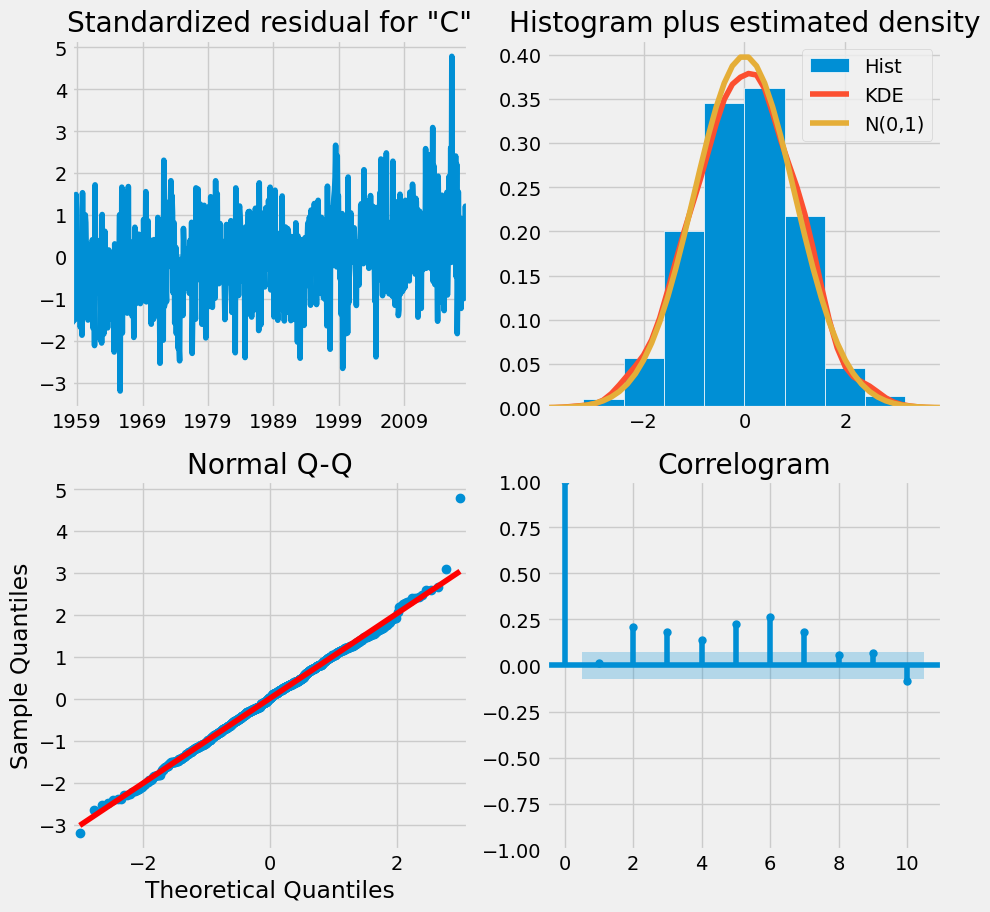

                               SARIMAX Results                                
Dep. Variable:                CO2_ppm   No. Observations:                  727
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -443.257
Date:                Mon, 11 Dec 2023   AIC                            906.514
Time:                        03:50:39   BIC                            952.390
Sample:                    03-01-1958   HQIC                           924.218
                         - 09-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.001     22.119      0.000       0.030       0.036
ar.L1          2.6469      0.026    100.322      0.000       2.595       2.699
ar.L2         -3.4606      0.064    -53.684      0.0

In [33]:
# En iyi model sırası (4,4)’tür. 
# Bu sırayı kullanarak veriyi uyumla ve ardından model hatalarını analiz ederek modeli teşhis et.



# Modeli oluştur ve uyumla
model = sm.tsa.statespace.SARIMAX(co2, order=(4, 1, 4), trend='c')
results = model.fit()

# 4 tanısal grafik oluştur
results.plot_diagnostics(figsize=(10, 10))
plt.show()

# Özeti yazdır
print(results.summary())


# 2. Mevsimsel ARIMA Modelleri

Bu bölümde, daha karmaşık verileri uyumlamak için mevsimsel ARIMA modellerini nasıl kullanacağımızı tartışacağız. Bu veriyi mevsimsel ve mevsimsel olmayan parçalara ayırmayı öğrenecek ve ardından tüm ARIMA araçlarınızı bir tane daha küresel tahmin zorluğunda kullanma fırsatını elde edeceksiniz.

# 2.1. Mevsimsel zaman serilerine giriş

Mevsimsel bir zaman serisi, düzenli olarak tekrarlanan öngörülebilir desenlere sahiptir. Bu özelliği mevsimsellik olarak adlandırsak da, bu herhangi bir süre boyunca tekrarlanabilir. Bu mevsimsel döngüler, her yıl tekrarlanabilir, güneş kremi satışları gibi, her hafta tekrarlanabilir, bir parka gelen ziyaretçi sayısı gibi, veya her gün tekrarlanabilir, bir web sitesindeki kullanıcı sayısı gibi.

Herhangi bir zaman serisinin üç ana bileşenden oluştuğu düşünülebilir: trend, mevsimsel bileşen ve artık. Aşağıdaki şekil, daha önce kullanılan şeker üretimi zaman serisinin üç bileşenini göstermektedir.


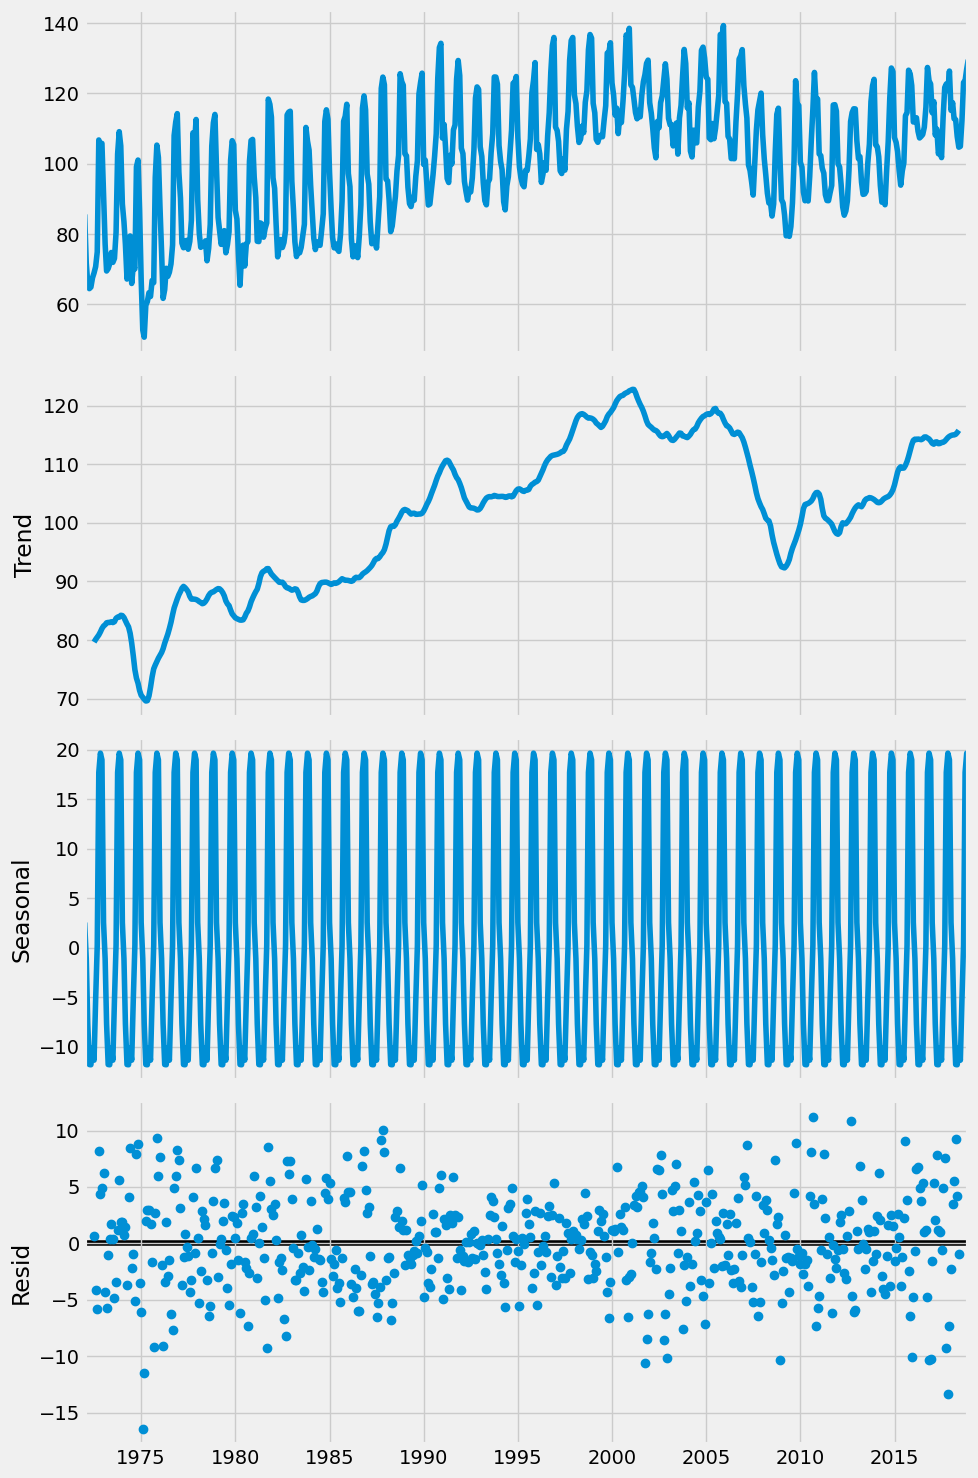

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

candy = pd.read_csv('Datasets/ARIMA/candy_production.csv', 
            index_col='date',
            parse_dates=True)

# Veriyi ayrıştır
decomp_results = seasonal_decompose(candy, period=12)

# Ayrıştırılmış veriyi çiz
plt.rcParams["figure.figsize"] = (10, 15)
decomp_results.plot()
plt.show()


Yukarıdaki şekilden veride bir mevsimsellik olduğu açıktır. Döngü burada 12 aydır. Ancak bu, fonksiyona bir parametre olarak verilmiştir. Eğer zaman serisinin döngüsünü veya mevsimsellik döngüsünü bulmak istiyorsak, bir yöntem, ACF'yi kullanmak ve korelasyon deseninin tekrarlandığı gecikmeyi gözlemlemektir. Ancak, verinin durağan olduğundan emin olmak önemlidir. Çünkü şeker üretimi verisi eğilimler içerdiği için durağan değildir, bu nedenle ilk farkı alarak durağana dönüştürebiliriz. Ancak bu sefer yalnızca zaman serisinin periyodunu bulmaya çalışıyoruz ve ACF grafiği, hareketli ortalama çıkarılarak daha net olacaktır. Hareketli ortalamayı hesaplamak için DataFrame'in .rolling yöntemini kullanıyoruz, burada pencere boyutunu geçiririz ve ayrıca .mean yöntemini kullanırız. Bu için herhangi büyük bir pencere boyutu, N, işe yarayacaktır. Bu değeri, orijinal zaman serisinden çıkarırız ve NA değerlerini bırakırız. Zaman serisi şimdi durağan ve ACF grafiğini yorumlamak daha kolay olacaktır.

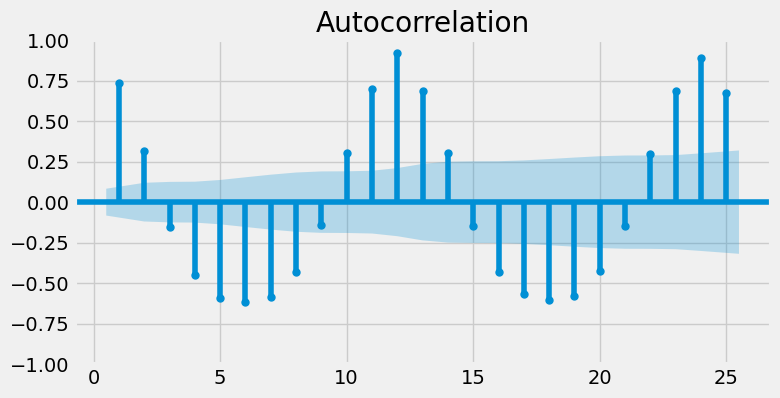

In [36]:
# 5 adımlık uzun vadeli hareketli ortalama çıkar
candy = candy - candy.rolling(5).mean()
# NaN değerlerini kaldır
candy = candy.dropna()

# ACF kullanarak mevsimsel veriyi tanımlama

# Şekil oluştur
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# ACF çiz
plot_acf(candy.dropna(), ax=ax, lags=25, zero=False)
plt.show()



Detrended verilerin ACF'sini çizdikten sonra, belirgin bir şekilde 12 adımlık bir mevsimsel periyodu görebiliriz. Veri mevsimsel olduğundan, bir ARIMA modelini uyarlamaya çalışırsak her zaman korele residual'lar bırakılacaktır. Bu, verideki tüm bilgileri kullanmadığımız anlamına gelir ve bu nedenle en iyi tahminleri yapmıyoruz demektir. Bu, bir sonraki alt bölümde gösterileceği gibi mevsimsel ARIMA'nın kullanılmasıyla çözülecektir.

Önceki alt bölümde verideki mevsimselliği nasıl bulacağımızı tartıştık, bu alt bölümde ise mevsimselliği kullanarak daha doğru tahminler yapmayı öğreneceğiz. Bunu yapmak için mevsimsel ARIMA (SARIMA) kullanılır. Bir SARIMA modelini uyarlamak, aynı anda biri mevsimsel diğeri mevsimsel olmayan kısım olmak üzere iki farklı ARIMA modelini uyarlamak gibidir. Bu nedenle iki modelimiz olur ve iki set sıralamamız olur. Mevsimsel olmayan (p), fark (d) ve hareketli ortalama (q) kısımları için bir dizi sıralamamız vardır. Ayrıca, bu sıralamaya mevsimsel olmayan kısma eklenmiş yeni bir sıralama, yani mevsimsel döngünün uzunluğu olan S'dir.

Şimdi SARIMA ve ARIMA modellerini daha fazla karşılaştıralım. Aşağıda parametreleri (2,0,1) olan ARIMA modelinin denklemi bulunmaktadır. Bu denklemde, zaman serisini kendisiyle gecikmeler-1 ve 2 ve şoka karşı regresyon yapıyoruz.

ARIMA(2,0,1) modeli:

y(t) = a(1) y(t-1) + a(2) y(t-2) + m(1) ϵ(t-1) + ϵ(t)

Aşağıda, haftada bir döngü süresi olan basit bir SARIMA modelinin denklemi bulunmaktadır. Bu SARIMA modelinde sadece mevsimsel bir kısım bulunmaktadır; mevsimsel olmayan sıralamaları sıfır olarak ayarladık. Zaman serisini kendisiyle bir mevsimin gecikmelerinde ve iki mevsimin gecikmelerinde ve şoka karşı regresyon yapıyoruz.

SARIMA(0,0,0)(2,0,1)7 modeli:

y = a (7)y(t-7) + a(14)y(t-14) + m(7) ϵ(t-7) + ϵ(t)

Bu özel SARIMA modeli, mevsimsel, haftalık desenleri yakalayabilir, ancak yerel, günlük desenleri yakalayamaz. Eğer bir SARIMA modeli oluşturur ve mevsimsel olmayan sıralamaları da eklersek, o zaman her iki deseni de yakalayabiliriz.

Bir SARIMA modeli uyarlamak, bir ARIMA modeli uyarlamakla neredeyse aynıdır. Model nesnesini içe aktarıp önceki gibi uyuturuz. Tek fark, modeli başlatırken mevsimsel sıralamayı ve düzenli sıralamayı belirtmemiz gerektiğidir.

```
import statsmodels.api as sm

model = sm(df, order=(p,d,q), seasonal_order=(P,D,Q,S))

```
Bu, bulmamız gereken birçok model sıralaması olduğu anlamına gelir. Bir önceki alt bölümde, S mevsimsel periyodunu ACF kullanarak nasıl bulacağımızı öğrendik. Sonraki görev, mevsimsel farkın sırasını bulmaktır.

Bir zaman serisini durağan yapmak için mevsimsel fark uygulamamız gerekebilir. Mevsimsel farklama, en son zaman serisi değerini çıkarmak yerine, bir döngü önceki zaman serisi değerini çıkardığımız bir farklamadır. Mevsimsel farkı df.diff yöntemini kullanarak alabiliriz. Bu sefer bir integer S, yani mevsimsel döngünün uzunluğu, geçiririz.

Eğer zaman serisi bir trend gösteriyorsa, normal farkı alırız. İki farkın sırasını bulduktan ve zaman serisini durağan hale getirdikten sonra, diğer model sıralamalarını bulmamız gerekiyor. Mevsimsel olmayan sıralamaları (p,q) bulmak için farklılaştırılmış zaman serisinin ACF ve PACF'sini çiziyoruz. Mevsimsel sıralamaları (P,Q) bulmak için farklılaştırılmış zaman serisinin birden çok mevsimsel adımdaki ACF ve PACF'sini çiziyoruz. Daha sonra aynı ACF ve PACF kurallarının tablosunu kullanarak mevsimsel sıralamayı çalıştırabiliriz. Bu mevsimsel ACF ve PACF grafiklerini plot_acf ve plot_pacf fonksiyonları kullanarak yaparız, ancak bu sefer lags parametresini bir maksimum yerine bir lag listesine ayarlarız. Bu, ACF ve PACF'yi sadece bu belirli gecikmelerde çizer.

Bunu bir önceki alt bölümde kullanılan şeker üretimi zaman serisine uygulayalım. Verinin mevsimsel periyodu 12 adımdır. Bu nedenle önce mevsimsel etkiyi kaldırmak için mevsimsel farkı alacağız ve ardından trend etkisini kaldırmak için bir adım farkı alacağız

<Axes: xlabel='date'>

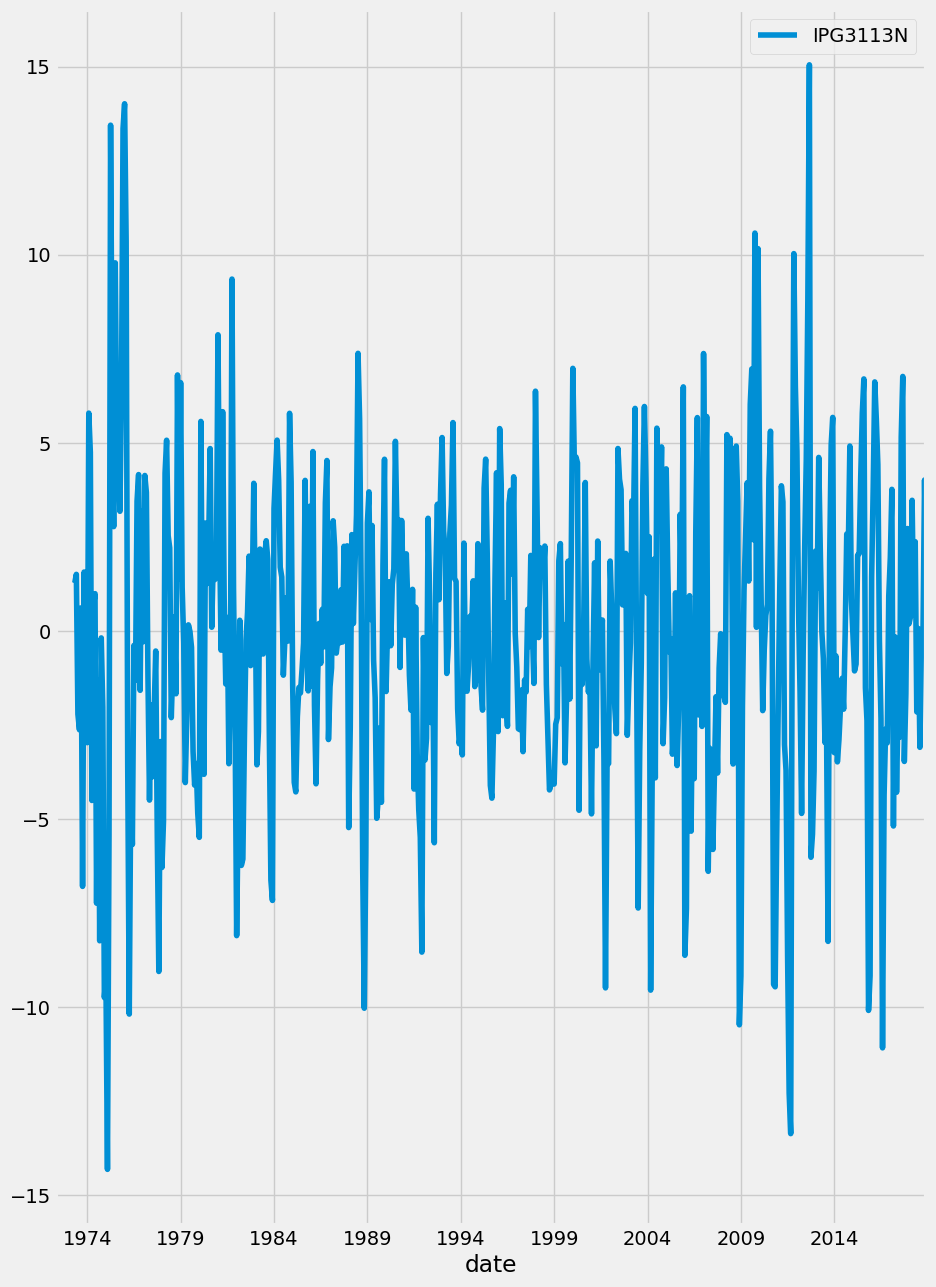

In [37]:
S = 12
candy_diff = candy.diff(S)
candy_diff.plot()


<Axes: xlabel='date'>

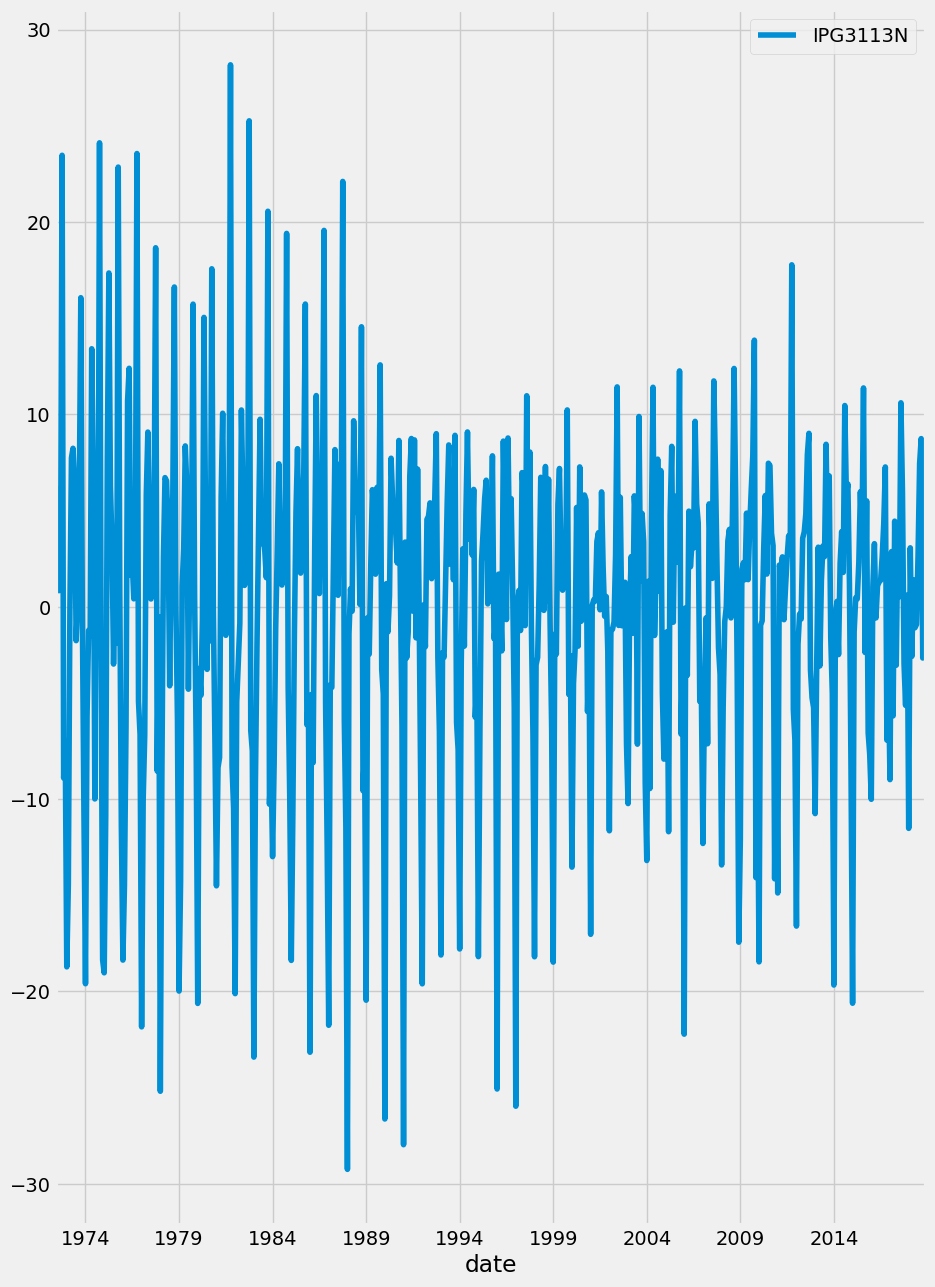

In [38]:
candy_diff = candy.diff()
candy_diff = candy_diff.dropna()
candy_diff.plot()

Test istatistiği: -12.534999311054039
p değeri: 2.3824843186272722e-23


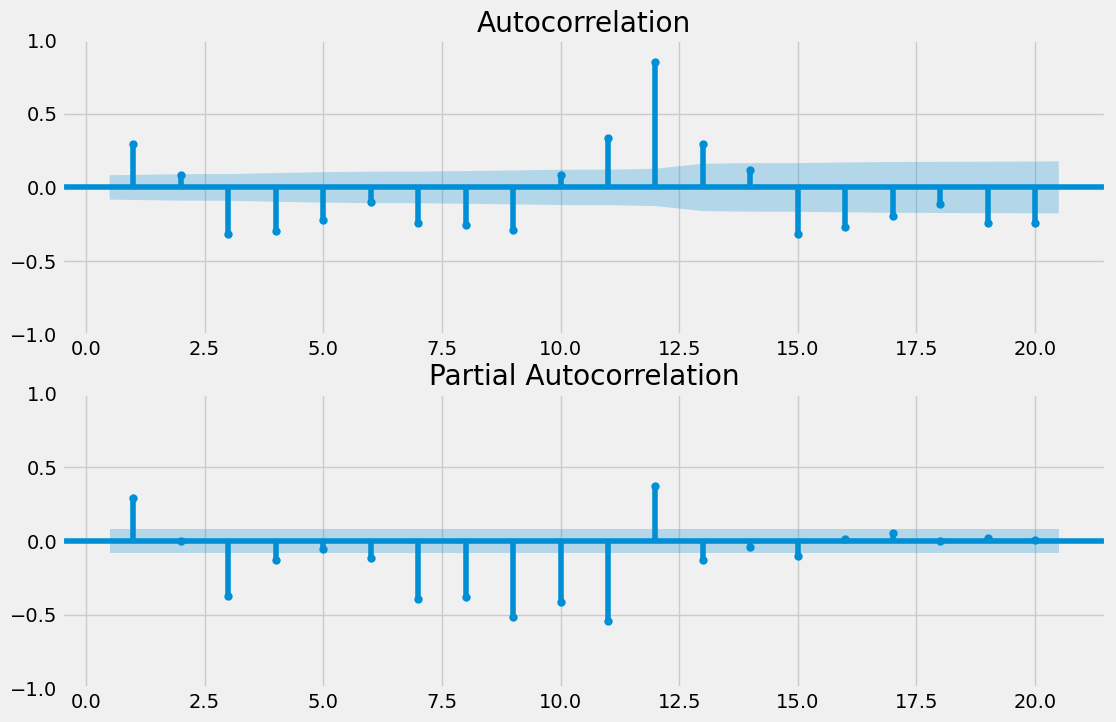

In [39]:
# Zaman serisinin artık durağan olduğundan emin olmak için augment Dickey-Fuller 
# testini uygulayalım.

# Dickey-Fuller testini çalıştır
sonuc = adfuller(candy_diff)

# Test istatistiğini yazdır
print('Test istatistiği:', sonuc[0])

# p değerini yazdır
print("p değeri:", sonuc[1])


# p değeri 0.05'ten küçük olduğu için null hipotezi reddedilebilir ve 
# zaman serisinin artık durağan olduğunu varsayabiliriz. 
# Bundan sonra, ACF ve PACF'yi çizerek mevsimsiz model parametrelerini bulacağız.

# Mevsimsiz model parametrelerini bul
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Figür oluştur
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# ax1 üzerine birikimli otokorelasyon fonksiyonunu (ACF) çiz
plot_acf(candy_diff, lags=20, zero=False, ax=ax1)

# ax2 üzerine birikimli kısmi otokorelasyon fonksiyonunu (PACF) çiz
plot_pacf(candy_diff, lags=20, zero=False, ax=ax2)

plt.show()


In [40]:
import statsmodels.api as sm
order_aic_bic =[]

# p değerlerini 0-4 arasında döngüye al
for p in range(5):
    # q değerlerini 0-4 arasında döngüye al
    for q in range(5):
      
        try:
            # ARMA(p,q) modelini oluştur ve uyumla
            model = sm.tsa.statespace.SARIMAX(candy_diff, order=(p, 1, q))
            results = model.fit()
            
            # Siparişi ve sonuçları yazdır
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Model siparişi ve AIC/BIC skorları DataFrame'i oluştur
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

# AIC ve BIC'ye göre sıralayalım

# AIC'ye göre sırala
print("AIC'ye göre sıralanmış modeller ")
print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# BIC'ye göre sırala
print("BIC'ye göre sıralanmış modeller ")
print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))


/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71490D+00    |proj g|=  1.78944D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.156D-06   3.715D+00
  F =   3.7149031384444280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.6

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  3.47548D+00    |proj g|=  1.03122D-02

At iterate   15    f=  3.46570D+00    |proj g|=  3.06150D-03

At iterate   20    f=  3.46527D+00    |proj g|=  2.13562D-03

At iterate   25    f=  3.46513D+00    |proj g|=  1.12995D-03

At iterate   30    f=  3.46510D+00    |proj g|=  4.39767D-04

At iterate   35    f=  3.46510D+00    |proj g|=  2.02259D-04

At iterate   40    f=  3.46510D+00    |proj g|=  2.68379D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     48      1     0     0   2.541D-05   3.465D+00
  F =   3.4650987682429086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrain


At iterate    5    f=  3.55159D+00    |proj g|=  2.85544D-02

At iterate   10    f=  3.51002D+00    |proj g|=  3.32942D-02

At iterate   15    f=  3.50454D+00    |proj g|=  4.16616D-03

At iterate   20    f=  3.50306D+00    |proj g|=  9.87688D-03

At iterate   25    f=  3.50294D+00    |proj g|=  2.65603D-04

At iterate   30    f=  3.50293D+00    |proj g|=  9.00854D-05

At iterate   35    f=  3.50293D+00    |proj g|=  1.71129D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     41      1     0     0   3.753D-05   3.503D+00
  F =   3.5029260466457610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/B


At iterate   15    f=  3.47234D+00    |proj g|=  5.14498D-03

At iterate   20    f=  3.46743D+00    |proj g|=  4.00322D-03

At iterate   25    f=  3.46707D+00    |proj g|=  1.19307D-04

At iterate   30    f=  3.46703D+00    |proj g|=  2.08483D-04

At iterate   35    f=  3.46702D+00    |proj g|=  1.08099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     45      1     0     0   1.081D-05   3.467D+00
  F =   3.4670244326574795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   25    f=  3.42441D+00    |proj g|=  9.35282D-03

At iterate   30    f=  3.42261D+00    |proj g|=  1.47958D-03

At iterate   35    f=  3.42237D+00    |proj g|=  2.33388D-03

At iterate   40    f=  3.42236D+00    |proj g|=  4.04291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     46      1     0     0   1.537D-05   3.422D+00
  F =   3.4223635616064185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/B


At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72789D+00    |proj g|=  4.38738D-01

At iterate    5    f=  3.63785D+00    |proj g|=  1.33013D-01

At iterate   10    f=  3.57936D+00    |proj g|=  3.01224D-02

At iterate   15    f=  3.50757D+00    |proj g|=  3.24655D-02

At iterate   20    f=  3.50364D+00    |proj g|=  1.27780D-03

At iterate   25    f=  3.50299D+00    |proj g|=  1.43175D-03

At iterate   30    f=  3.50293D+00    |proj g|=  6.28815D-04

At iterate   35    f=  3.50293D+00    |proj g|=  1.71710D-04

At iterate   40    f=  3.50293D+00    |proj g|=  1.28474D-05

At iterate   45    f=  3.50292D+00    |proj g|=  8.22262D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



At iterate   15    f=  3.44004D+00    |proj g|=  1.26514D-02

At iterate   20    f=  3.43847D+00    |proj g|=  2.14331D-02

At iterate   25    f=  3.43797D+00    |proj g|=  1.06537D-02

At iterate   30    f=  3.43788D+00    |proj g|=  4.59173D-03

At iterate   35    f=  3.43786D+00    |proj g|=  6.86221D-04

At iterate   40    f=  3.43785D+00    |proj g|=  5.47694D-04

At iterate   45    f=  3.43785D+00    |proj g|=  7.69141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     54      1     0     0   4.113D-04   3.438D+00
  F =   3.4378529721968576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  3.44465D+00    |proj g|=  5.46243D-02

At iterate   15    f=  3.44080D+00    |proj g|=  2.03197D-02

At iterate   20    f=  3.43893D+00    |proj g|=  5.60441D-03

At iterate   25    f=  3.43858D+00    |proj g|=  1.97902D-03

At iterate   30    f=  3.43810D+00    |proj g|=  2.79841D-03

At iterate   35    f=  3.43762D+00    |proj g|=  5.45326D-03

At iterate   40    f=  3.43753D+00    |proj g|=  6.10946D-03

At iterate   45    f=  3.43747D+00    |proj g|=  1.53920D-03

At iterate   50    f=  3.43746D+00    |proj g|=  6.51905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     53   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ib

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59325D+00    |proj g|=  9.22134D-02

At iterate    5    f=  3.54002D+00    |proj g|=  1.55962D-01

At iterate   10    f=  3.44146D+00    |proj g|=  7.36526D-02

At iterate   15    f=  3.43307D+00    |proj g|=  2.09631D-02

At iterate   20    f=  3.42898D+00    |proj g|=  9.76388D-03

At iterate   25    f=  3.42862D+00    |proj g|=  2.77370D-04

At iterate   30    f=  3.42859D+00    |proj g|=  3.38471D-04

At iterate   35    f=  3.42859D+00    |proj g|=  2.73293D-04

At iterate   40    f=  3.42859D+00    |proj g|=  2.33756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     61      1     0     0   9.599D-04   3.272D+00
  F =   3.2715668408534411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53049D+00    |proj g|=  1.02543D-01

At iterate    5    f=  3.45731D+00    |proj g|=  2.98703D-02

At iterate   10    f=  3.44305D+00    |proj g|=  1.51812D-02

At iterate   15    f=  3.43927D+00    |proj g|=  1.10971D-02

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f=  3.43773D+00    |proj g|=  2.65429D-03

At iterate   40    f=  3.43771D+00    |proj g|=  9.67792D-04

At iterate   45    f=  3.43770D+00    |proj g|=  7.23776D-04

At iterate   50    f=  3.43770D+00    |proj g|=  5.65458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   5.655D-04   3.438D+00
  F =   3.4377029907959957     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem


At iterate   10    f=  3.43284D+00    |proj g|=  4.06280D-02

At iterate   15    f=  3.42299D+00    |proj g|=  3.51388D-02

At iterate   20    f=  3.41248D+00    |proj g|=  2.26843D-02

At iterate   25    f=  3.40703D+00    |proj g|=  4.54508D-02

At iterate   30    f=  3.39787D+00    |proj g|=  7.08246D-03

At iterate   35    f=  3.39742D+00    |proj g|=  5.16355D-03

At iterate   40    f=  3.39606D+00    |proj g|=  3.39322D-02

At iterate   45    f=  3.39528D+00    |proj g|=  1.99828D-02

At iterate   50    f=  3.39508D+00    |proj g|=  6.66301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ib


At iterate    5    f=  3.56488D+00    |proj g|=  3.98995D-04

At iterate   10    f=  3.56488D+00    |proj g|=  7.91514D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   7.915D-06   3.565D+00
  F =   3.5648786411175650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55781D+00    |proj g|=  5.64896D-02

At iterate    5    f=  3.53559D+00    |proj g|=  1.51805D-01

At iter

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  3.42742D+00    |proj g|=  7.81164D-02

At iterate   15    f=  3.40651D+00    |proj g|=  3.66206D-02

At iterate   20    f=  3.39508D+00    |proj g|=  8.02350D-03

At iterate   25    f=  3.38957D+00    |proj g|=  4.32984D-03

At iterate   30    f=  3.38815D+00    |proj g|=  1.94698D-03

At iterate   35    f=  3.38805D+00    |proj g|=  4.65635D-04

At iterate   40    f=  3.38804D+00    |proj g|=  1.05958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     45      1     0     0   6.234D-05   3.388D+00
  F =   3.3880395691906693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  3.46901D+00    |proj g|=  3.76475D-02

At iterate   10    f=  3.43353D+00    |proj g|=  1.17525D-02

At iterate   15    f=  3.43273D+00    |proj g|=  9.09439D-03

At iterate   20    f=  3.38472D+00    |proj g|=  1.79771D-01

At iterate   25    f=  3.33306D+00    |proj g|=  8.50975D-02

At iterate   30    f=  3.30046D+00    |proj g|=  2.82729D-02

At iterate   35    f=  3.22963D+00    |proj g|=  2.84924D-02

At iterate   40    f=  3.22150D+00    |proj g|=  9.89905D-03

At iterate   45    f=  3.22111D+00    |proj g|=  5.24586D-03

At iterate   50    f=  3.22019D+00    |proj g|=  5.34161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem


At iterate    5    f=  3.46374D+00    |proj g|=  7.70406D-02

At iterate   10    f=  3.43584D+00    |proj g|=  1.88659D-02

At iterate   15    f=  3.42788D+00    |proj g|=  3.82007D-02

At iterate   20    f=  3.42497D+00    |proj g|=  8.66221D-02

At iterate   25    f=  3.41906D+00    |proj g|=  4.07070D-01

At iterate   30    f=  3.41327D+00    |proj g|=  1.68488D-01

At iterate   35    f=  3.41281D+00    |proj g|=  9.54672D-03

At iterate   40    f=  3.41171D+00    |proj g|=  3.17687D-01

At iterate   45    f=  3.41036D+00    |proj g|=  6.45340D-03

At iterate   50    f=  3.41008D+00    |proj g|=  6.06835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


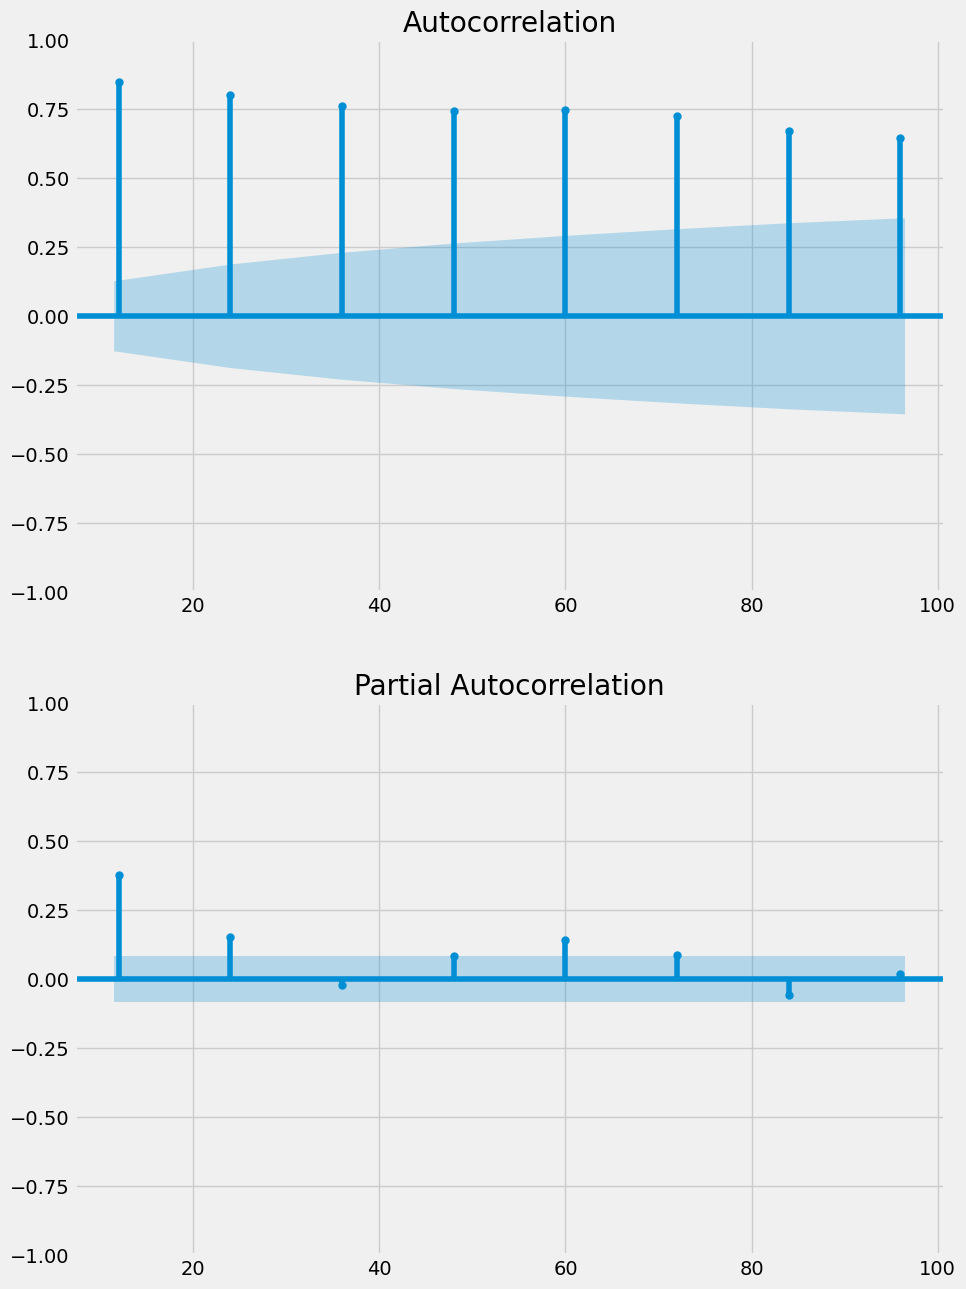

In [42]:
# En iyi model parametreleri (0,3). Ardından, 
# mevsimsel parametreleri bulmak için mevsimsel ACF ve PACF çizimlerini yapacağız.

# Mevsimsel ACF ve PACF Çizimleri
# Şekil oluştur
fig, (ax1, ax2) = plt.subplots(2,1)

# Mevsimsel ACF çiz
plot_acf(candy_diff, lags=[12,24,36,48,60,72, 84, 96], ax=ax1)

# Mevsimsel PACF çiz
plot_pacf(candy_diff, lags=[12,24,36,48,60,72, 84, 96], ax=ax2)
plt.show()

ACF düşük hızda artıyor ve PACF üç zaman gecikmesinden sonra kesiliyor. Bu nedenle model parametresi (0,3) olacaktır. Son adım, bu parametrelerle modeli uydurmaktır.

In [43]:
# SARIMA modelini uyarlama
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modeli başlat
S = 12
D = 1
d = 1
P = 0
Q = 3
p = 4
q = 3
model = SARIMAX(candy, order=(p, d, q), seasonal_order=(P, D, Q, S))

# Modeli uydur
results = model.fit()


/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/ibrahimediz/Desktop/BenimNotlar/env/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66906D+00    |proj g|=  2.19496D-01


 This problem is unconstrained.



At iterate    5    f=  2.50861D+00    |proj g|=  5.78111D-02

At iterate   10    f=  2.47301D+00    |proj g|=  2.81509D-02

At iterate   15    f=  2.46427D+00    |proj g|=  2.90351D-02

At iterate   20    f=  2.46207D+00    |proj g|=  1.11349D-02

At iterate   25    f=  2.46126D+00    |proj g|=  4.39673D-02

At iterate   30    f=  2.46080D+00    |proj g|=  1.31949D-02

At iterate   35    f=  2.46063D+00    |proj g|=  3.82876D-02

At iterate   40    f=  2.46054D+00    |proj g|=  4.53554D-03

At iterate   45    f=  2.46053D+00    |proj g|=  2.78911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     48     55   

## Süreç Otomasyonu ve Model Kaydetme

Daha önce ARIMA modeli düzeni için for döngüsü kullandık. Şimdi, mevsimsel düzenler de dahil olmak üzere, bu oldukça karmaşıktır. Neyse ki, bu işin çoğunu bizim için yapacak bir paket bulunmaktadır. Bu pmdarima paketidir. Bu paketten gelen auto_arima fonksiyonu, en iyi modeli bulmak için model düzenlerini döner. Fonksiyonun döndüğü nesne, araştırma tarafından bulunan en iyi modelin sonuçları nesnesidir. Bu nesne neredeyse tamamen bir statsmodels SARIMAX sonuçları nesnesine benzemekte olup, özet ve çizim teşhis yöntemlerine sahiptir.

In [44]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.1 MB/s eta 0:00:0000:0100:01
  Using cached scikit_learn-1.3.2-cp311-cp311-macosx_12_0_arm64.whl (9.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 4.2 MB/s eta 0:00:00
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)

[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


 ARIMA(5,0,4)(0,0,0)[0] intercept
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  560
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -1556.085
Date:                Mon, 11 Dec 2023   AIC                           3134.170
Time:                        09:16:40   BIC                           3181.778
Sample:                    05-01-1972   HQIC                          3152.760
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0588      0.049      1.205      0.228      -0.037       0.155
ar.L1          2.7357      0.047     57.716      0.000       2.643       2.829
ar.L2         -3.7

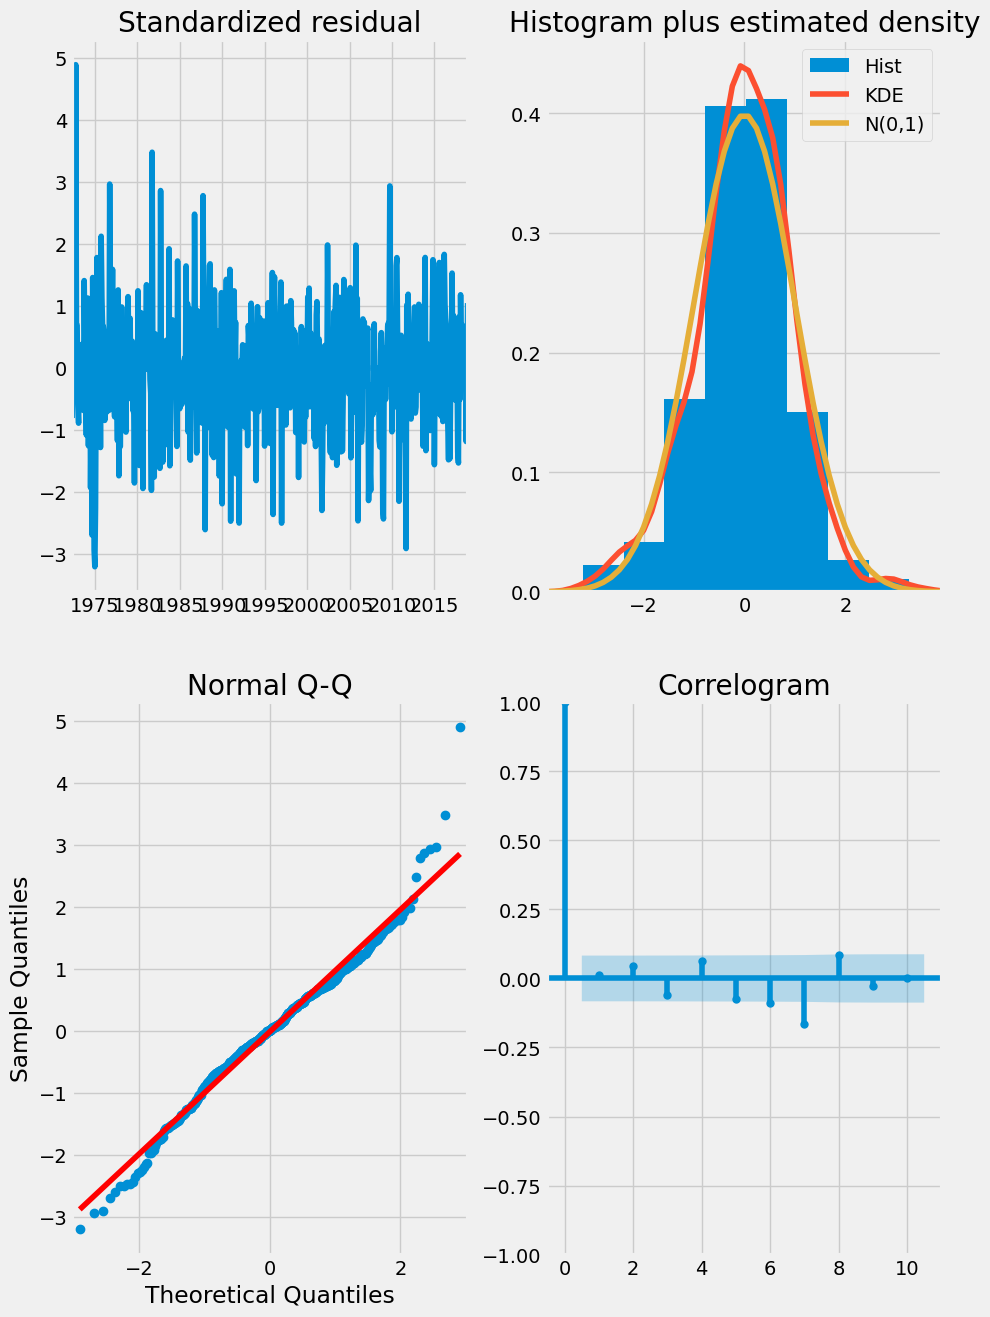

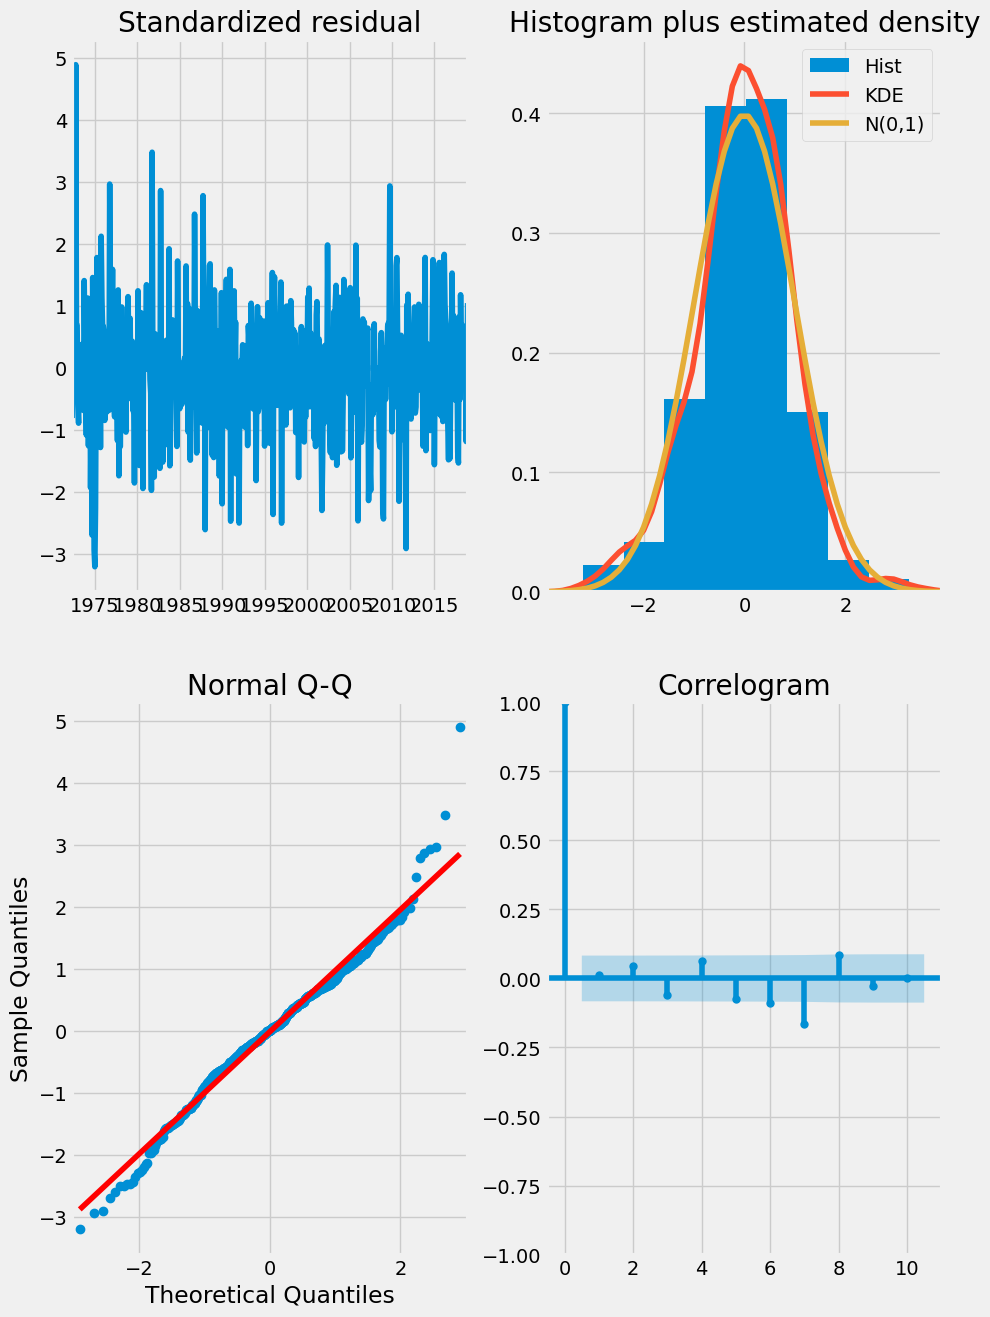

In [48]:
# Model sıraları üzerinde arama
import pmdarima as pm

sonuclar = pm.auto_arima(candy)
print(sonuclar)
print(sonuclar.summary())
sonuclar.plot_diagnostics()


Arama tarafından bulunan en iyi model sırası (2,3)’tir. Ancak, bu model mevsimsel bileşenleri dikkate almamıştır. Bunun için mevsimsel parametreyi 'true' olarak ayarlamamız gerekiyor. Ayrıca, mevsimsel dönemin uzunluğunu ve mevsimsel diferansiyasyonun sırasını belirtmemiz gerekiyor. Son olarak, birkaç non-sıra parametresi kullanacağız. Information_criterion kullanarak en iyi modeli AIC veya BIC'ye dayanarak seçebilirsiniz. Eğer information_criterion='aic' ise, AIC'ye dayalı olarak seçer ve eğer information_criterion='bic' ise, BIC'ye dayalı olarak seçer. Ayrıca, trace parametresini 'true' olarak ayarlayacağız; bu durumda, bu fonksiyon her bir model için AIC ve BIC'yi yazdırır. Kötü modelleri yok saymak için error_action='ignore' olarak ayarlayacağız. Stepwise'ı 'true' olarak ayarlayacağız, bu durumda fonksiyon, başlangıç model sırası tahmininden dışa doğru akıllı bir arama yöntemi kullanarak arama yapar. Bu, çalışma süresi ve hesaplama gücü tasarrufu sağlayabilir.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2794.720, Time=8.62 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3098.803, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2897.546, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2816.796, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3096.804, Time=0.09 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=2799.904, Time=4.70 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=2889.489, Time=2.07 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=2795.048, Time=8.19 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=2795.872, Time=9.77 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=2970.545, Time=0.39 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=2793.993, Time=6.03 sec
 ARIMA(2,0,2)(0,1,3)[12] intercept   : AIC=2795.721, Time=14.78 sec
 ARIMA(2,0,2)(1,1,3)[12] intercept   : AIC=2797.776, Time=22.55 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=2809.943, Time=4.66 sec
 ARIMA(2,0,1)(0,1

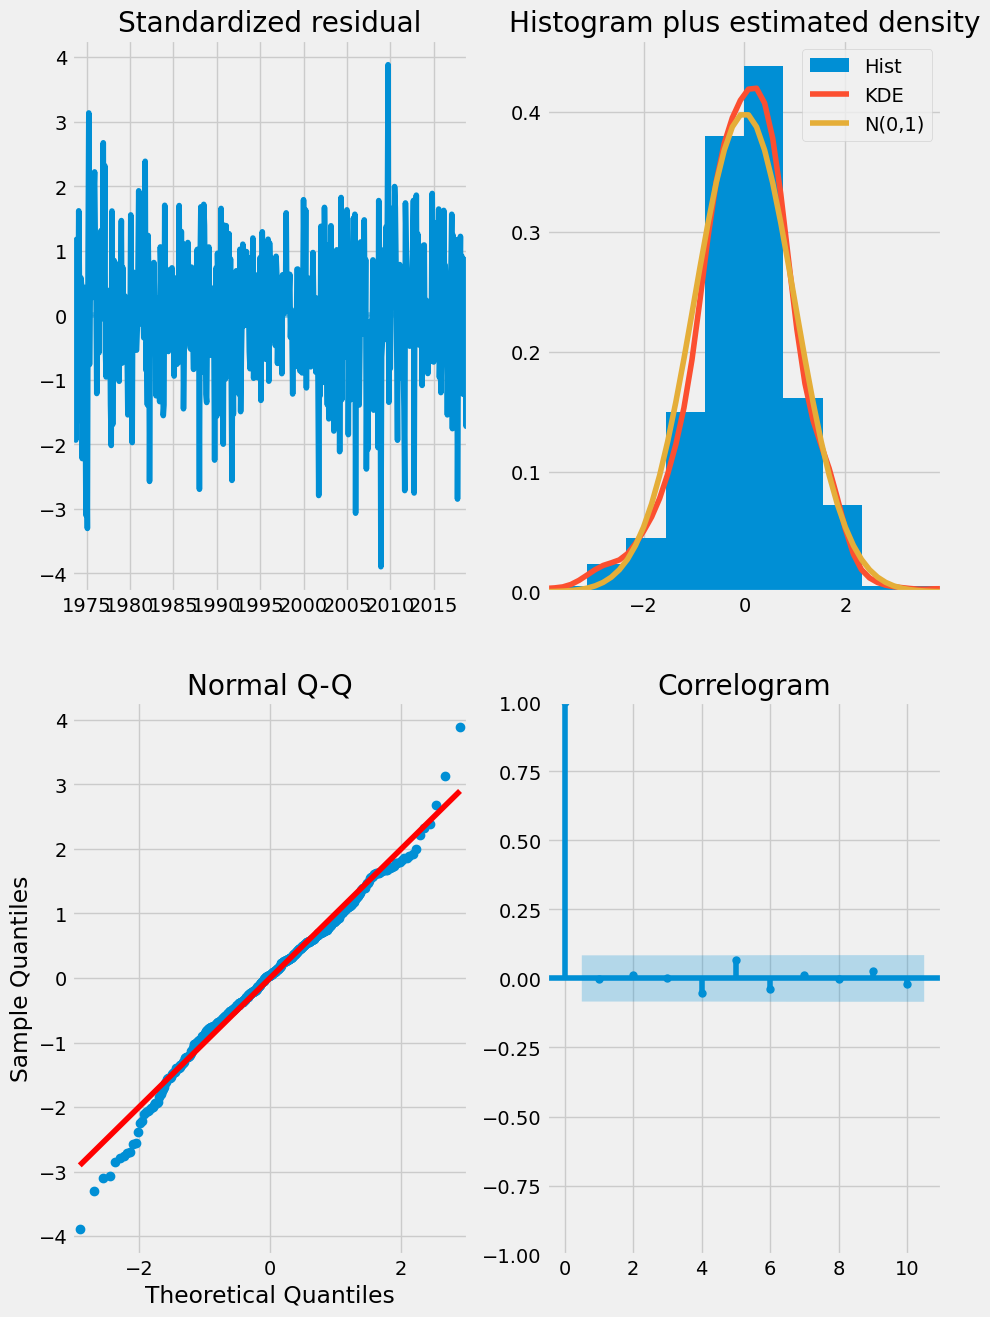

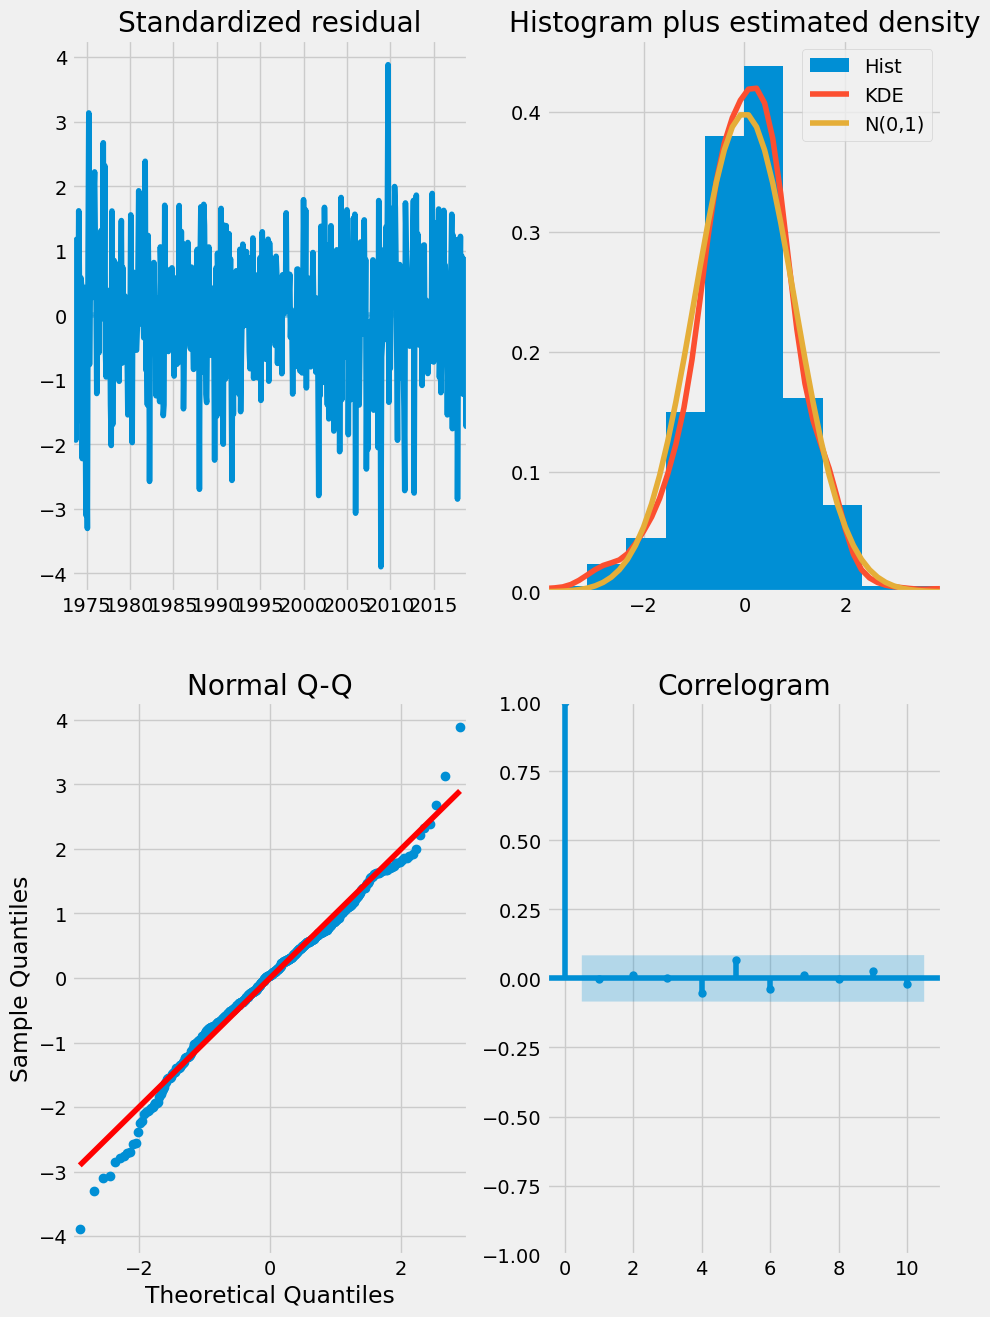

In [47]:
# Mevsimsel arama parametreleri

sonuclar = pm.auto_arima(candy, # veri
                        seasonal=True, # zaman serisi mevsimsel mi
                        m=12, # mevsimsel dönem
                        D=1, # mevsimsel fark sırası
                        start_P=1, # P için başlangıç tahmini
                        start_Q=1, # Q için başlangıç tahmini
                        max_P=4, # denenecek maksimum P değeri
                        max_Q=4, # denenecek maksimum Q değeri
                        information_criterion='aic', # en iyi modeli seçmek için kullanılır
                        trace=True, # eğitim sürecinde sonuçları yazdır
                        error_action='ignore', # çalışmayan sıraları yok say
                        stepwise=True,
                       )
print(sonuclar)
print(sonuclar.summary())
sonuclar.plot_diagnostics()


Bir modeli bu şekilde eğittikten sonra, onu kaydetmek ve daha sonra yüklemek isteyebilirsiniz. Bu işlemi joblib paketi kullanarak yapabilirsiniz. Modeli kaydetmek için joblib paketinin dump fonksiyonunu kullanırız. Bu fonksiyona model sonuçları nesnesini ve dosya yolu bilgisini geçiririz. Daha sonra yeni tahminler yapmak istediğimizde bu modeli tekrar yükleyebiliriz. Bunun için joblib paketinin load fonksiyonunu kullanırız.

In [49]:
# Model nesnelerini kaydetme
# joblib'i içe aktar
import joblib
# Bir dosya yolu seç
dosya_yolu = 'model.pkl'
# Modeli dosya yoluna kaydet
joblib.dump(sonuclar, dosya_yolu)

# Modeli yükleme
# Bir dosya yolu seç
dosya_yolu ='model.pkl'
# Model nesnesini dosya yolundan yükle
yuklenen_model = joblib.load(dosya_yolu)


eni veriniz varsa ve eğitilmiş modelinizi güncellemek istiyorsanız, model.update(new_data) fonksiyonunu kullanabilirsiniz. Bu, model sırasını tekrar seçme işlemi olmadığından, büyük miktarda yeni veri ile güncelleme yapılıyorsa Box-Jenkins yönteminin başlangıcına geri dönmek en iyisi olabilir.

## SARIMA ve Mevsimsel Zaman Serileri için Box-Jenkins
Daha önce ARIMA modelleri için Box-Jenkins yöntemini ele almıştık. Model sırasının belirlenmesi, modelin tahmini veya uyumlanması, model hatalarının teşhisi ve nihayet üretim aşamalarını kapsıyoruz. SARIMA modelleri için, yöntemin tek değişecek adımı belirleme adımı olacaktır. Belirleme adımında, bir zaman serisinin mevsimsel olup olmadığını belirleme ve eğer öyleyse mevsimsel periyodunu bulma görevlerini ekliyoruz. Ayrıca, mevsimsel zaman serisini durağan hale getirmek için dönüşümleri düşünmemiz gerekiyor, bunlar arasında mevsimsel ve mevsimsel olmayan farklar ve diğer dönüşümler bulunmaktadır. Bazen bir zaman serisini durağan hale getirmek için bir mevsimsel fark veya mevsimsel olmayan bir fark uygulama seçeneğimiz olacak. İyi bir kural, asla bir sezonluk farkın ötesinde kullanmamanız ve toplamda asla iki fark siparişi kullanmamanız gerektiğidir. Bazen bir zaman serisini durağan hale getirebilirsiniz, ya bir mevsimsel fark ya da mevsimsel olmayan bir fark kullanarak.

İki tür mevsimsellik vardır: zayıf mevsimsellik ve güçlü mevsimsellik. Zayıf mevsimsellikte, zaman serisindeki mevsimsel salınımlar her zaman aynı görünmeyecek ve belirlemesi daha zor olacaktır. Güçlü mevsimsellikte ise zaman serisindeki mevsimsel desen güçlü olacaktır. Güçlü bir mevsimsel desene sahipseniz, her zaman bir mevsimsel fark siparişi kullanmalısınız. Bu, mevsimsel salınımın gelecekteki dinamik tahminlerinizde solmaksızın uzun bir süre kalmasını sağlar. Zayıf bir mevsimsel desen kullanıyorsanız, sadece gerekli olduğunda kullanmalısınız.

ARIMA modellemede olduğu gibi, uygun olmadan önce zaman serilerimize başka dönüşümler de uygulamamız gerekebilir. Mevsimsel desen eklediğimizde, mevsimsel model sadece trendden biraz ekler veya çıkar, bu durumda herhangi bir dönüşüm uygulamamız gerekmez. Mevsimsel desen çarpanlı ise, mevsimsel salınımın genliği veri yukarı yönlü eğilim gösterdiğinde büyür veya aşağı yönlü eğilim gösterdiğinde küçülür. Mevsimsel desen çarpanlı ise, SARIMA modeli bunu ek dönüşümler olmadan uygun yapamaz. Bu durumu ele almak için verinin logaritma dönüşümünü alırız ve ardından modellemesini yaparız.